In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from dir import *
from VAE_models.VAE_model import *
from VAE_models.VAE_model_enhanced import *
from VAE_models.VAE_model_2 import *
from VAE_models.VAE_model_single import *
from training import *
from extras import *
from sklearn.decomposition import PCA

plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"Current working directory: {current_dir}")
print(f"Parent directory: {parent_dir}")

Current working directory: /Users/anastasiiashcherbakova/git_projects/masters_project/large_dataset_new_loss
Parent directory: /Users/anastasiiashcherbakova/git_projects/masters_project


# Contents:
#### - [1) Data exploration](#data_exploration)
[1.1) General data exploration](#general_exploration)
[1.2) PCA](#general_exploration)
#### - [2) Data preprocessing](#data_preprocessing)
[2.1) Dataset preprocessing](#dataset_preprocessing)
[2.2) Conversing the dataset into splits and dataloaders](#dataloaders)
#### - [3) Essential genes manipulatioins](#essential)
#### - [4) Training of full dataset (train_full_dataset.py script on the CS account)](#training)
[4.1) Full dataset (base model and enhanced model)](#full_dataset)

<a id='data_exploration'></a>
# 1) Data exploration 

<a id='general_exploration'></a>
## 1.1) General data exploration

In [3]:
essential_genes = pd.read_csv(PAPER_ESSENTIAL_GENES)

In [4]:
large_data = pd.read_csv(TEN_K_DATASET, index_col=[0], header=[0])

In [5]:
# Turning all sample names uppercase
large_data.columns = large_data.columns.str.upper()

In [6]:
large_data

,41004_G02_CONTIGS_PACBIO,50884_F01_CONTIGS_PACBIO,AIAW00000000,AIBY00000000,AIFN00000000,NC_002655,NC_002695,NC_011353,NC_013008,NC_017906,...,ESC_PA2010AA_AS,ESC_PA2013AA_AS,ESC_PA2014AA_AS,ESC_PA2016AA_AS,ESC_PA2019AA_AS,ESC_PA2021AA_AS,ESC_PA2023AA_AS,ESC_PA2315AA_AS,ESC_RA2551AA_AS,ESC_RA2561AA_AS
Strain,,,,,,,,,,,,,,,,,,,,,
Lineage,1,1,1,1,1,1,1,1,1,1,...,51,51,51,51,51,51,51,51,51,51
group_5501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_6055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
group_2149_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2067_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2068_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
large_data.sum(axis=1).sort_values()

Strain
group_569           1
group_4401_2        1
group_5102          1
group_5100_2        1
group_5099_3        1
                ...  
hldD             7512
group_4462_2     7512
grxC             7512
diaA             7512
Lineage         55565
Length: 55040, dtype: int64

In [8]:
sum(large_data.sum(axis=0) < 4000)

10

In [9]:
phylogroup_data = pd.read_csv(TEN_K_DATASET_PHYLOGROUPS, index_col=[0], header=[0])

In [10]:
phylogroup_data

,Phylogroup
ID,
ESC_CA4458AA_AS,E
ESC_CA5810AA_AS,E
11657_7#79,B2
ESC_SA7073AA_AS,B1
SRS3528668,Not Determined
...,...
39111_C02,Not determined
ESC_SA2343AA_AS,E
ESC_SA2344AA_AS,E


In [11]:
phylogroup_data.value_counts()

Phylogroup    
E                 3428
B2                2311
Not Determined    1708
B1                1535
D                  345
A                  335
Not determined     232
F                  157
Shigella            67
C                   28
Name: count, dtype: int64

In [12]:
data_without_lineage = large_data.drop(index=['Lineage'])
large_data_t = np.array(data_without_lineage.transpose())

print(f"Full dataset shape: {large_data_t.shape}")


Full dataset shape: (7512, 55039)


In [13]:
threshold_data = []
thresholds = np.linspace(0, 50, num=50)
data_without_lineage = large_data.drop(index=['Lineage'])

for i in thresholds:
    row_sums = data_without_lineage.sum(axis=1)
    threshold_data.append(len(data_without_lineage[row_sums >= i]))


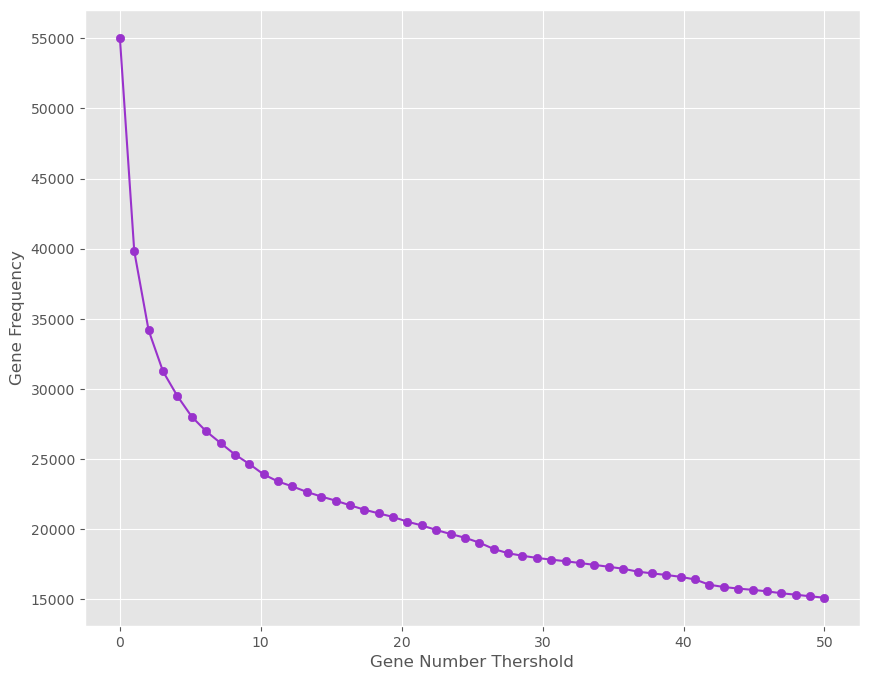

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(thresholds, threshold_data, color='darkorchid')
plt.plot(thresholds, threshold_data, color='darkorchid')
plt.xlabel("Gene Number Thershold")
plt.ylabel("Gene Frequency")
# plt.savefig("figures/gene_frequency_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
gene_count_frequency = large_data.sum(axis=1)

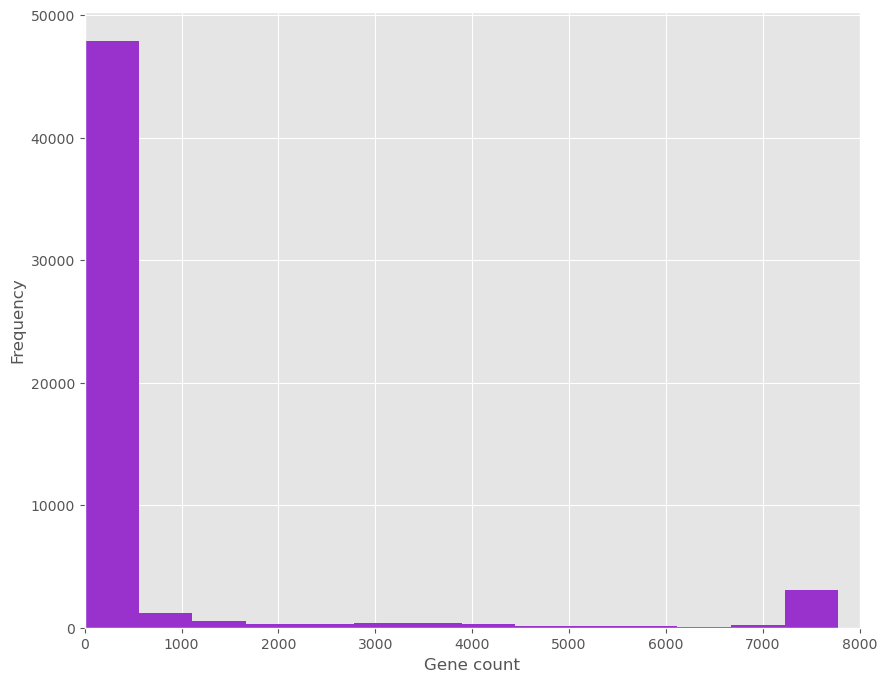

In [16]:
plt.figure(figsize=(10,8))
plt.hist(gene_count_frequency, color='darkorchid', bins=100)
plt.xlim(0, 8000)
plt.xlabel('Gene count')
plt.ylabel('Frequency')
# plt.savefig("figures/gene_count_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [17]:
genome_size_frequency = large_data.sum(0)

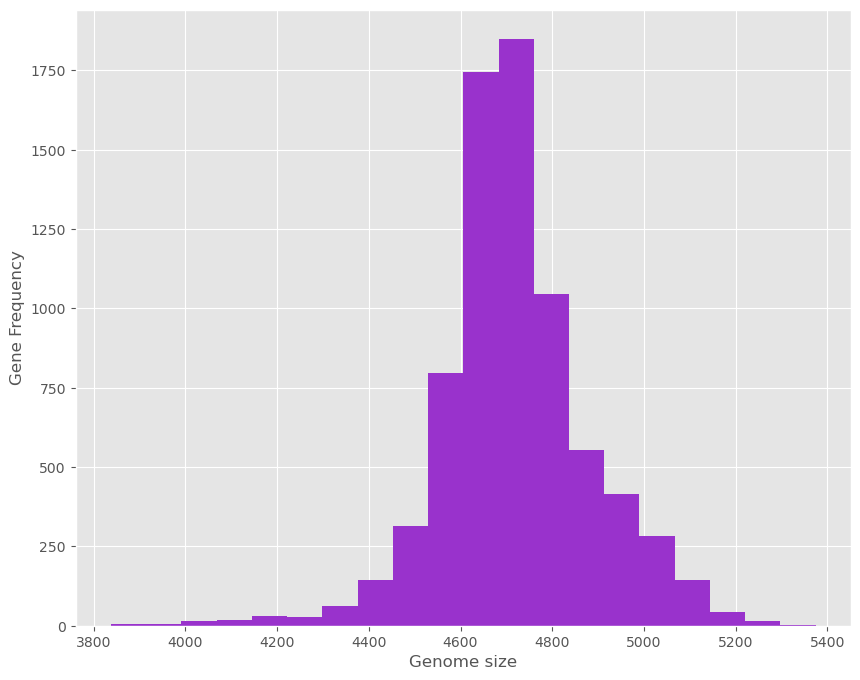

In [18]:
plt.figure(figsize=(10,8))
plt.hist(genome_size_frequency, bins=20, color='darkorchid')
plt.xlabel('Genome size')
plt.ylabel('Gene Frequency')
# plt.savefig("figures/genome_size_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [19]:
print(f"Smallest genome: {large_data.sum(0).min()}")

Smallest genome: 3838


## 1.2) PCA

In [20]:
# Inner merge dataset
merged_df = pd.merge(data_without_lineage.transpose(), phylogroup_data, how='inner', left_index=True, right_on='ID')

In [21]:
merged_df

,group_5501,group_4783,group_4456,group_6055,group_2859,group_3832,group_4223,group_2401,group_1236,group_3245,...,group_2066_1,mukF_1,group_955_2,group_1382_5,group_2149_7,group_2067_4,group_2068_8,group_2069_3,group_2071_4,Phylogroup
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
AIBY00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
AIFN00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
NC_002655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
NC_002695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D
ESC_PA2023AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D
ESC_PA2315AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D


In [22]:
print(f"merged dataset shape: {merged_df.shape}")

merged dataset shape: (5953, 55040)


In [23]:
merged_df.iloc[:, :-1]

,group_5501,group_4783,group_4456,group_6055,group_2859,group_3832,group_4223,group_2401,group_1236,group_3245,...,group_1609_5,group_2066_1,mukF_1,group_955_2,group_1382_5,group_2149_7,group_2067_4,group_2068_8,group_2069_3,group_2071_4
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
all_genes = merged_df.columns # all genes and phylogroup

In [25]:
merged_df['Phylogroup'].value_counts()

Phylogroup
E           2496
B2          1982
B1           877
D            299
A            111
F            102
Shigella      63
C             23
Name: count, dtype: int64

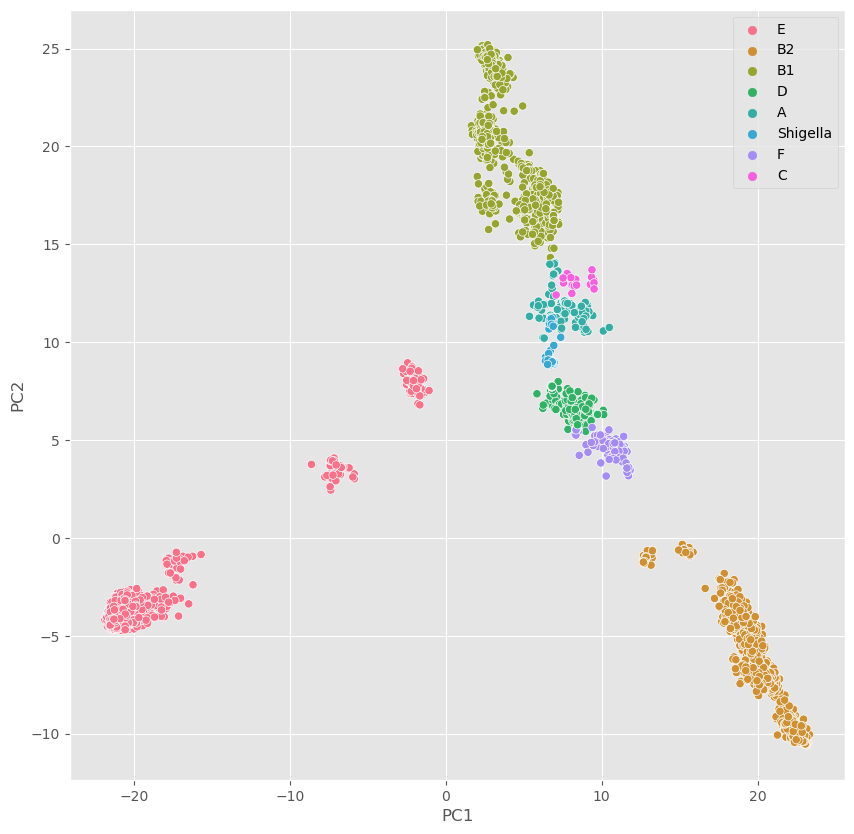

In [26]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(merged_df.iloc[:, :-1])
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = merged_df.Phylogroup.tolist(), data=df_pca)
# plt.savefig("figures/PCA_graph_BD_Phylogroup.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 2) Data preprocessing

## 2.1) Dataset preprocessing 

In [27]:
data_array_t = np.array(merged_df.iloc[:, :-1])
phylogroups_array = np.array(merged_df.iloc[:, -1])

In [28]:
print("Checking dataset shapes")
print(f"Values array: {data_array_t.shape}")
print(f"Phylogroups array: {phylogroups_array.shape}")

Checking dataset shapes
Values array: (5953, 55039)
Phylogroups array: (5953,)


## 2.2) Conversing the dataset into splits and dataloaders

In [29]:
# Convert to PyTorch tensor
data_tensor = torch.tensor(data_array_t, dtype=torch.float32)

# Split into train and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data_tensor, phylogroups_array, test_size=0.3, random_state=12345)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.3333, random_state=12345)
test_phylogroups = test_labels

# Set batch size
batch_size = 32

# TensorDataset
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

# Set laoders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [30]:
print(f"Train data shape {train_data.shape}")
print(f"Test data shape {test_data.shape}")
print(f"Val data shape {val_data.shape}")

Train data shape torch.Size([4167, 55039])
Test data shape torch.Size([596, 55039])
Val data shape torch.Size([1190, 55039])


# 3) Essential genes manipulatioins

In [31]:
# Creating an array of essential genes fromt the paper and flattening it 
essential_genes_array = np.array(essential_genes).flatten()

In [32]:
print(f"Total number of essential genes present in the paper: {len(essential_genes_array)}")

Total number of essential genes present in the paper: 358


In [33]:
# Creating a gene mask for the essential arrays for more optimal counting of the essential arrays present in the samples 
essential_genes_mask = np.isin(all_genes, essential_genes_array)

In [34]:
print(f"Total number of essential genes present in the dataset: {np.sum(essential_genes_mask)}")

Total number of essential genes present in the dataset: 316


In [35]:
# figuring out which genes are not present in the dataset
subset_not_in_essential_genes_mask = essential_genes[~np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

In [36]:
# figuring out which genes are not present in the dataset
subset_in_essential_genes_mask = essential_genes[np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

In [37]:
absent_genes = np.array(subset_not_in_essential_genes_mask).flatten()

In [38]:
print(f"Number of genes not present in the dataset: {len(absent_genes)}")

Number of genes not present in the dataset: 42


In [39]:
present_genes = np.array(subset_in_essential_genes_mask).flatten()

In [40]:
print(f"Number of genes present in the dataset: {len(present_genes)}") 

Number of genes present in the dataset: 316


In [41]:
# Seeing if the genes split into multiple parts are the essential genes 
matched_columns = []

for gene in absent_genes:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['msbA_2' 'msbA_1' 'msbA_3' 'fabG_2' 'fabG_1' 'fabG_3' 'fabG_1_1'
 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2' 'fabG2' 'fabG_2_3' 'lolD_2'
 'lolD_1' 'lolD_3' 'lolD_3_1' 'lolD_4' 'topA_3' 'topA_3_1' 'topA_2'
 'topA_1' 'topA_3_2' 'metG_2' 'metG_2_1' 'metG_2_2' 'fbaA_2' 'fbaA_1'
 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1' 'higA_3' 'higA-1' 'higA1' 'higA1_1'
 'higA_1' 'higA_3_1' 'higA_1_1' 'higA_3_2' 'higA1_2' 'higA_2' 'higA1_3'
 'higA-2' 'higA_2_1' 'lptB_1' 'lptB_1_1' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2'
 'ssb_4' 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1' 'lptG_1'
 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'dnaC_3' 'dnaC_1' 'dnaC_2'
 'dnaC_1_1' 'dnaC_1_2' 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5' 'dnaC_2_1'
 'dnaC_1_6' 'dnaC_2_2']
73


In [42]:
# Manually creating the array of genes which is divided into chunks
divided_genes_prefixes = ['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',  'lptG', 'dnaC'] # 'higA-1', 'higA1','higA-2', 'ssbA' dont count 

In [43]:
not_present = np.array(list(set(absent_genes) - set(divided_genes_prefixes)))

In [44]:
print(f"Genes which are still not present in the dataset after prefix extraction: {not_present}:")
print(f"Total number: {len(not_present)}:")

Genes which are still not present in the dataset after prefix extraction: ['ynbG' 'yffS' 'cydX' 'ykfM' 'yjbS' 'ymiB' 'ispU' 'yobI' 'ycaR' 'cohE'
 'racR' 'yqeL' 'ygeN' 'ydcD' 'ymfE' 'dicA' 'pheM' 'ydaS' 'trpL' 'yciS'
 'ydaE' 'ydhL' 'yedN' 'ttcC' 'yihA' 'dfp' 'ygeF' 'yddL' 'yncH' 'cydC'
 'ygeG']:
Total number: 31:


In [45]:
# Creating a new array of the unique genes presetn in the dataset (single name + divided into chunks genes)
# print("New total number of the genes present in the dataset: ", np.concatenate(present_genes, divided_genes_prefixes))

In [46]:
# Creating a new array of the genes () both sigle name and didived) presetn in the dataset 
combined_array = np.concatenate((present_genes, divided_genes))

In [47]:
len(combined_array)

389

In [48]:
# Creating a new gene mask including the divided essential genes 
essential_genes_mask = np.isin(all_genes, combined_array)

In [49]:
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [50]:
essential_genes_df

,higA_3,topA_3,higA-1,dnaC_3,higA1,ssbA,fbaA_2,holB,metG_2,relB,...,higA-2,lptG_2_1,ssb_1_3,topA_3_2,ssb_5,ssbA_1,metG_2_2,dnaC_2_2,higA_2_1,lptG_1_1
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
gene_sums = essential_genes_df.sum()
zero_sum_genes = gene_sums[gene_sums == 0].index.tolist()
print(zero_sum_genes)
print(len(zero_sum_genes))

['dnaC_1_3', 'ssb_1_2', 'lptG_2_1']
3


Dataframe of just absent essential genes (including the ones that are split up)

In [52]:
absent_essential_genes_df = pd.DataFrame()

for prefix in absent_genes:
    cols_to_merge = essential_genes_df.filter(regex=f'^{prefix}')
    absent_essential_genes_df[prefix] = (cols_to_merge.sum(axis=1) > 0).astype(int)

In [53]:
absent_essential_genes_df

,ispU,ykfM,cydX,cydC,msbA,ycaR,fabG,lolD,ymfE,cohE,...,ygeN,fbaA,higA,lptB,dfp,yihA,yjbS,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIBY00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIFN00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002655,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002695,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2023AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2315AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1


Datafarme of the genes that are divided into chunks

In [54]:
intermediate = essential_genes_df.drop(columns=divided_genes)

In [55]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,holA,lptE,leuS,lnt,ybeY,glnS,fldA,hemB,iraM,lpd
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


Adding the absent essential genes that are present in the dataframe to the overall dataframe of the genes presemt in the datatframe

In [56]:
row_sums = absent_essential_genes_df.sum(axis=0)
columns_to_add = absent_essential_genes_df.columns[row_sums != 0]

In [57]:
columns_to_add

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [58]:
absent_essential_genes_df[columns_to_add]

,msbA,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,1


In [59]:
absent_essential_genes_df[columns_to_add].columns

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [60]:
# Add these selected columns to the original DataFrame
for col in absent_essential_genes_df[columns_to_add].columns:
    intermediate[col] = absent_essential_genes_df[col]

Intermediate dataframe to plot the frequency of the present in the dataframe genes:

In [61]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [62]:
datatset_EG = list(intermediate.columns)

In [63]:
from collections import defaultdict

In [64]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Group gene positions by their prefix
groups_of_gene_positions = defaultdict(list)
for idx, gene in enumerate(all_genes):
    prefix = extract_prefix(gene)
    groups_of_gene_positions[prefix].append(idx)

# Convert defaultdict to a regular dict
groups_of_gene_positions = dict(groups_of_gene_positions)

# Print the dictionary to verify
for prefix, positions in groups_of_gene_positions.items():
    print(f"{prefix}: {positions}")

group: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 

In [65]:
# Precompute essential gene positions
essential_gene_positions = {}
for gene in essential_genes_array:
    if gene in groups_of_gene_positions.keys():
        essential_gene_positions[gene] = groups_of_gene_positions[gene]

In [66]:
essential_gene_positions

{'rpsT': [15341],
 'ribF': [15340],
 'ileS': [15339],
 'lspA': [15338, 36962, 42383],
 'ispH': [15336],
 'dapB': [15334, 40591],
 'folA': [1511, 15316],
 'lptD': [15308],
 'ftsL': [15283],
 'ftsI': [15282, 40806],
 'murE': [15281, 40807],
 'murF': [15280, 33264, 33265, 40809],
 'mraY': [15279, 40810],
 'murD': [15278, 33262, 33263],
 'ftsW': [15277],
 'murG': [15276],
 'murC': [15275],
 'ftsQ': [15273],
 'ftsA': [15272],
 'ftsZ': [15271],
 'lpxC': [15270],
 'secA': [15268],
 'coaE': [11933],
 'aceF': [11944],
 'lpd': [19570],
 'can': [11956],
 'hemL': [11985, 42003],
 'erpA': [11987, 37359],
 'dapD': [11996],
 'map': [11998, 39912],
 'rpsB': [11999],
 'tsf': [12000, 48412],
 'pyrH': [12001],
 'frr': [12002],
 'dxr': [12003],
 'cdsA': [12006, 12100, 29339, 30377, 34707],
 'bamA': [12008],
 'lpxD': [12010, 46997],
 'fabZ': [12011],
 'lpxA': [12012],
 'lpxB': [12013],
 'dnaE': [9123, 12015, 18059, 23498, 31303, 41020, 50504],
 'accA': [12016, 40738],
 'tilS': [12019, 40737],
 'proS': [164

In [67]:
# Initialize a Series to store the abundance of each essential gene
essential_gene_abundance = pd.Series(0, index=essential_genes_array)

# Map positions to actual column names in the DataFrame
column_names = merged_df.columns

# Iterate over precomputed essential gene positions
for gene, positions in essential_gene_positions.items():
    if len(positions) == 1:
        pos = positions[0]
        column_name = column_names[pos]
        essential_gene_abundance[gene] = merged_df[column_name].sum()
    else:
        column_subset = [column_names[pos] for pos in positions]
        essential_gene_abundance[gene] = merged_df[column_subset].sum(axis=1).sum()


In [68]:
gene_sums = intermediate.sum()

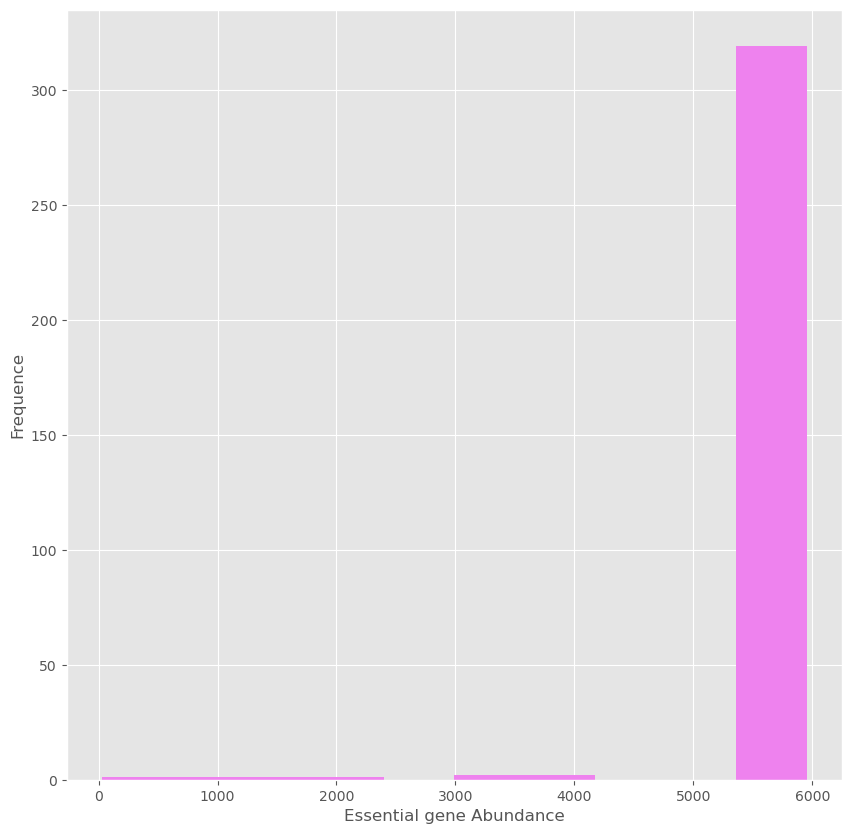

In [69]:
plt.figure(figsize=(10, 10))
plt.hist(gene_sums, color='violet')
plt.xlabel('Essential gene Abundance')
plt.ylabel('Frequence')
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_frequency.pdf", format="pdf", bbox_inches="tight")

In [70]:
print(f"Minimal gene abundance: {gene_sums.min()}")

Minimal genome abundance: 30


# 4) Training of full dataset (train_full_dataset.py script on the CS account)

## 4.1) Full dataset (base model and enhanced model)

In [71]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = '/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/8_final_dataset_new_params/saved_KL_annealing_VAE_BD_100.pt'

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[4.6422319e-03 2.6865826e-05 1.0128156e-06 ... 1.2629135e-05
  1.3932486e-05 1.8151166e-05]
 [7.8819925e-03 1.1628979e-04 3.7128277e-05 ... 3.7033626e-06
  4.0519958e-06 1.1907454e-05]
 [9.4004103e-04 1.0379215e-07 1.2522975e-06 ... 9.1445577e-07
  9.1789127e-07 3.1228268e-07]
 ...
 [5.7364605e-02 1.3466117e-06 6.6016614e-06 ... 6.7113018e-07
  7.2026410e-07 9.3049482e-07]
 [9.5345235e-01 7.8759388e-11 4.4799780e-12 ... 1.6268668e-08
  1.7636649e-08 1.0567059e-08]
 [1.9428076e-02 3.2539309e-03 8.7234395e-05 ... 6.7659123e-05
  7.2674411e-05 1.8672948e-04]]


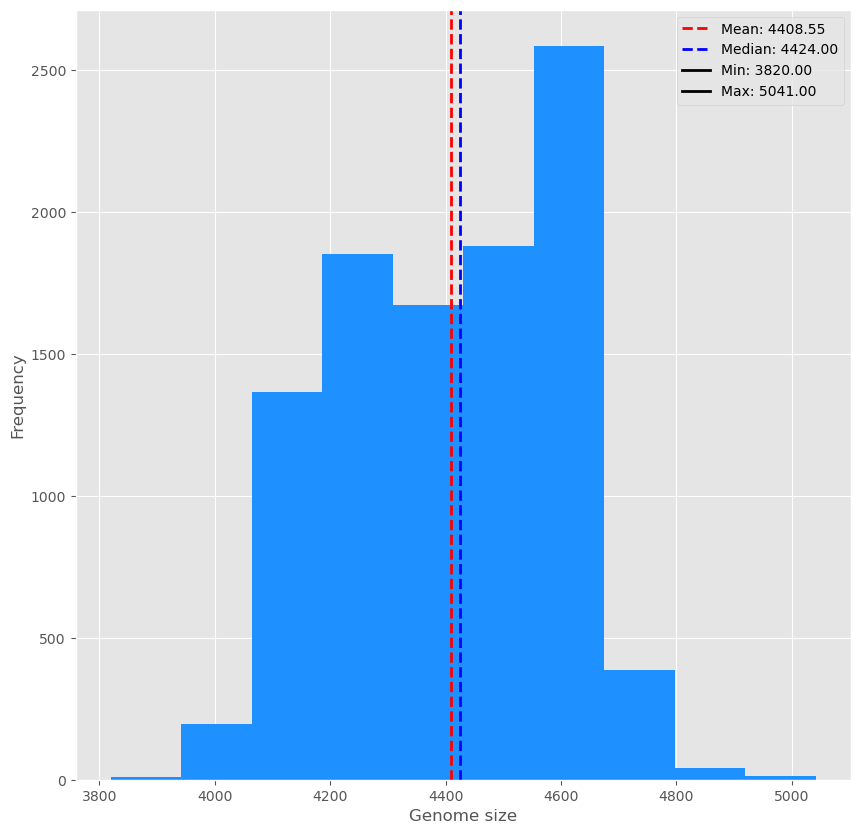

In [72]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_final_dataset_new_params.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [73]:
binary_generated_samples.sum(axis=1).min()

3820.0

In [74]:
np.mean(binary_generated_samples.sum(axis=1))

4408.5469

In [75]:
np.median(binary_generated_samples.sum(axis=1))

4424.0

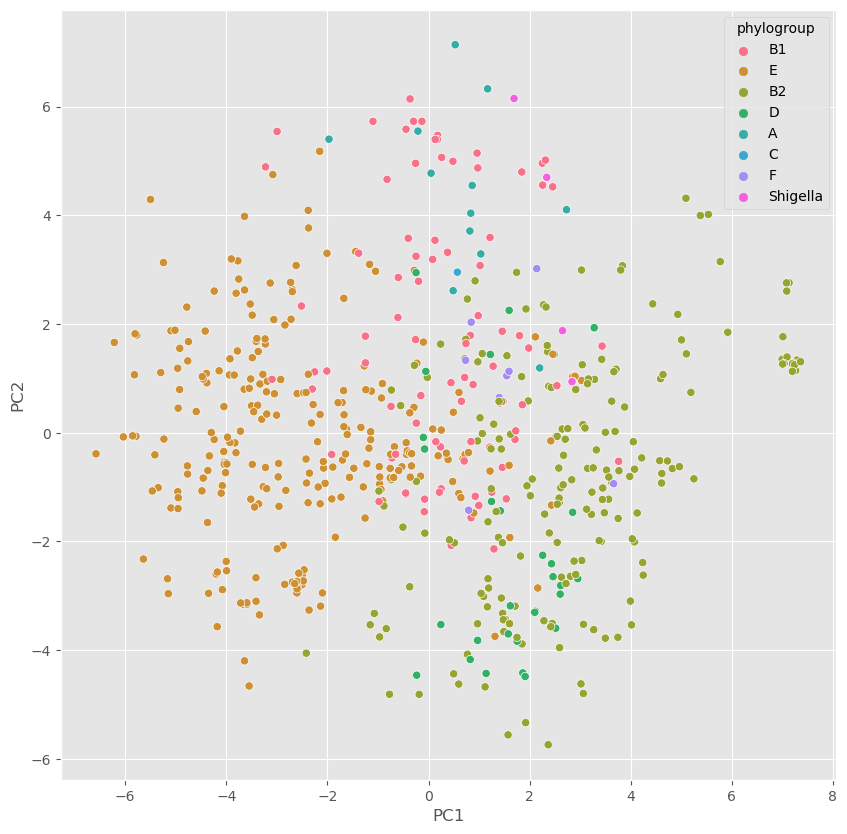

In [76]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [77]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

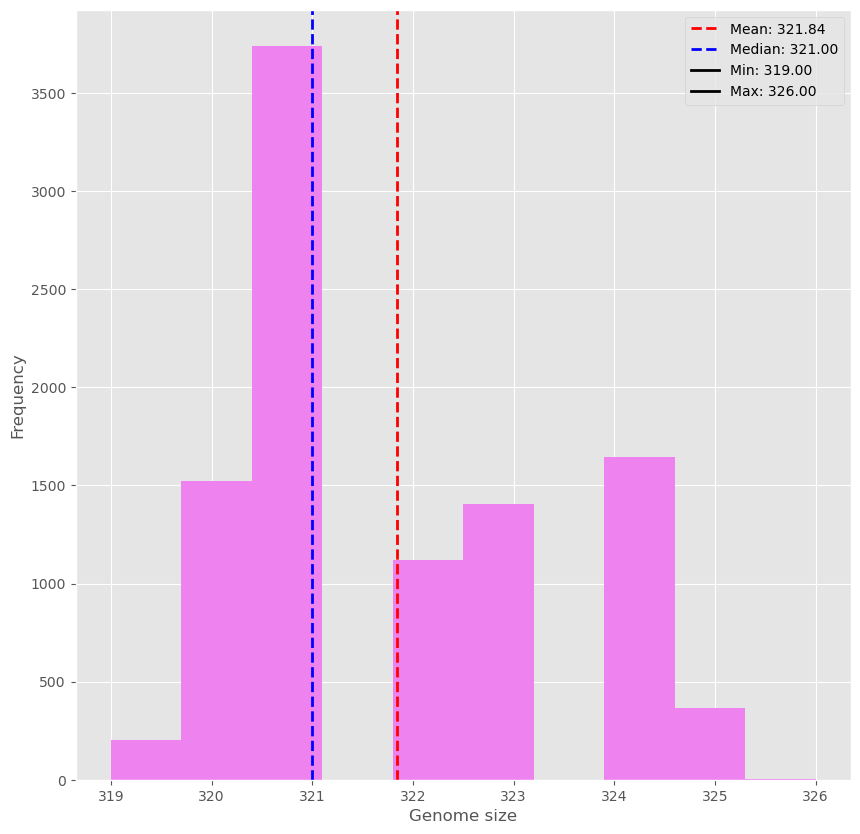

In [78]:
plot_color = "violet"
figure_name ="/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_final_dataset_new_params.pdf"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

----------

In [79]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/9_final_dataset_enhanced/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[2.8649902e-05 1.9688864e-06 2.0848452e-09 ... 6.8321349e-10
  1.0008827e-09 3.0770084e-09]
 [2.0735998e-01 1.0413363e-05 6.7519072e-06 ... 1.8455822e-06
  2.0856476e-06 1.7892775e-06]
 [1.5287574e-04 4.0412342e-05 3.8283714e-03 ... 9.5752966e-06
  9.4940970e-06 6.2931604e-06]
 ...
 [5.2112120e-04 2.1859007e-08 3.0501550e-07 ... 1.0091307e-05
  1.1120367e-05 1.4289429e-05]
 [2.0728324e-02 1.3221231e-04 1.0426000e-03 ... 2.2581344e-07
  2.3925421e-07 2.6757178e-07]
 [3.3746824e-02 1.3267425e-05 1.7143648e-04 ... 4.5817487e-05
  4.5492085e-05 3.4649285e-05]]


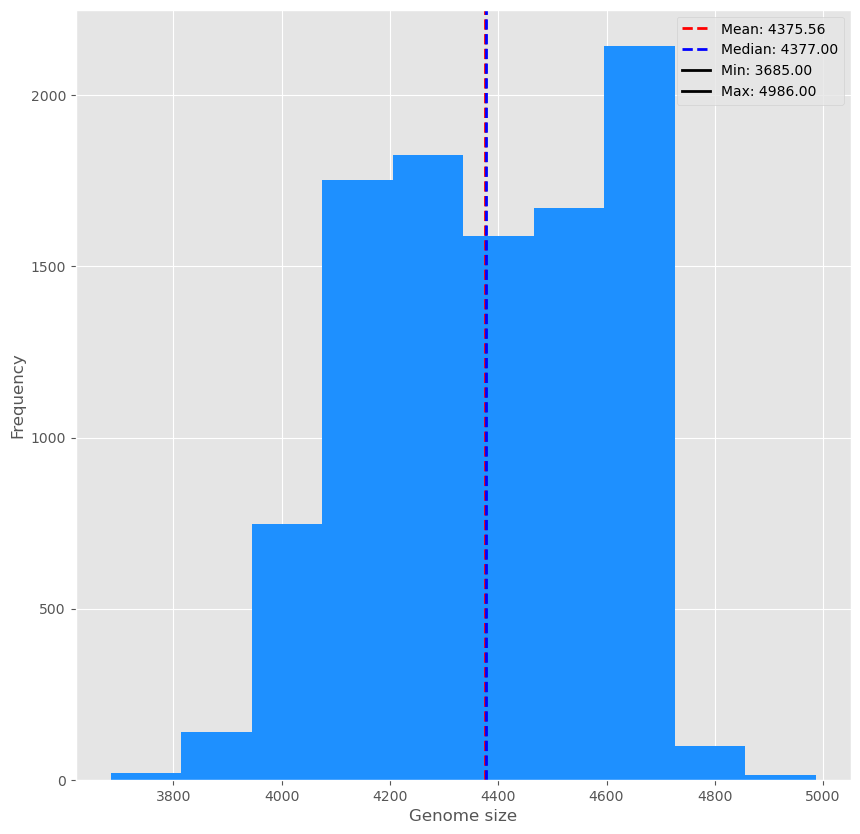

In [80]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_9_final_dataset_enhanced.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [81]:
binary_generated_samples.sum(axis=1).min()

3685.0

In [82]:
np.mean(binary_generated_samples.sum(axis=1))

4375.5564

In [83]:
np.median(binary_generated_samples.sum(axis=1))

4377.0

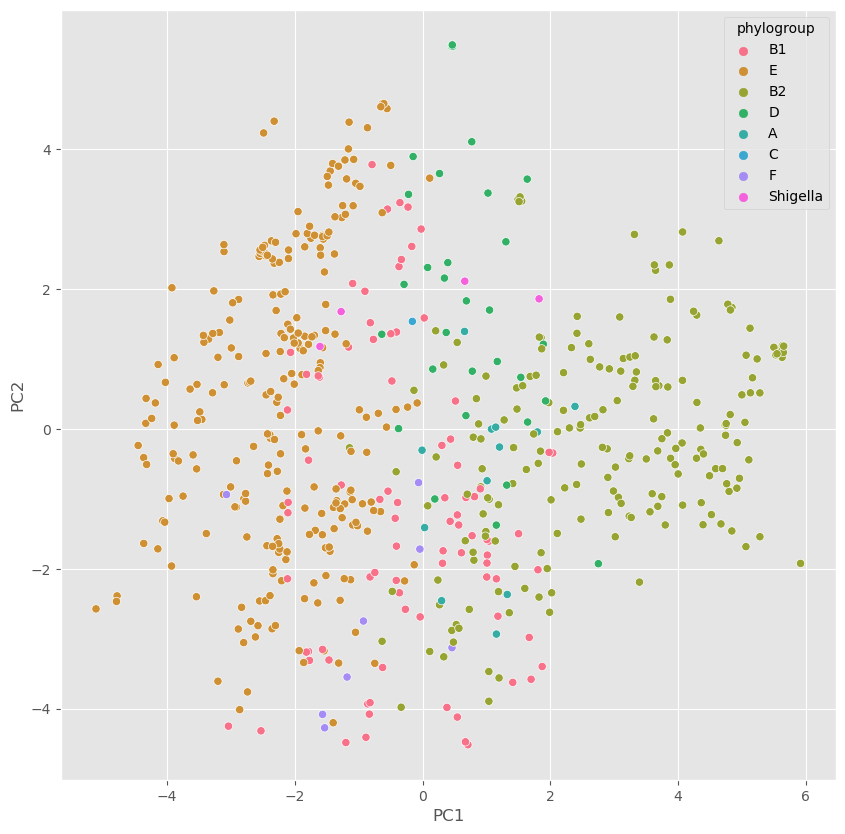

In [84]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [85]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

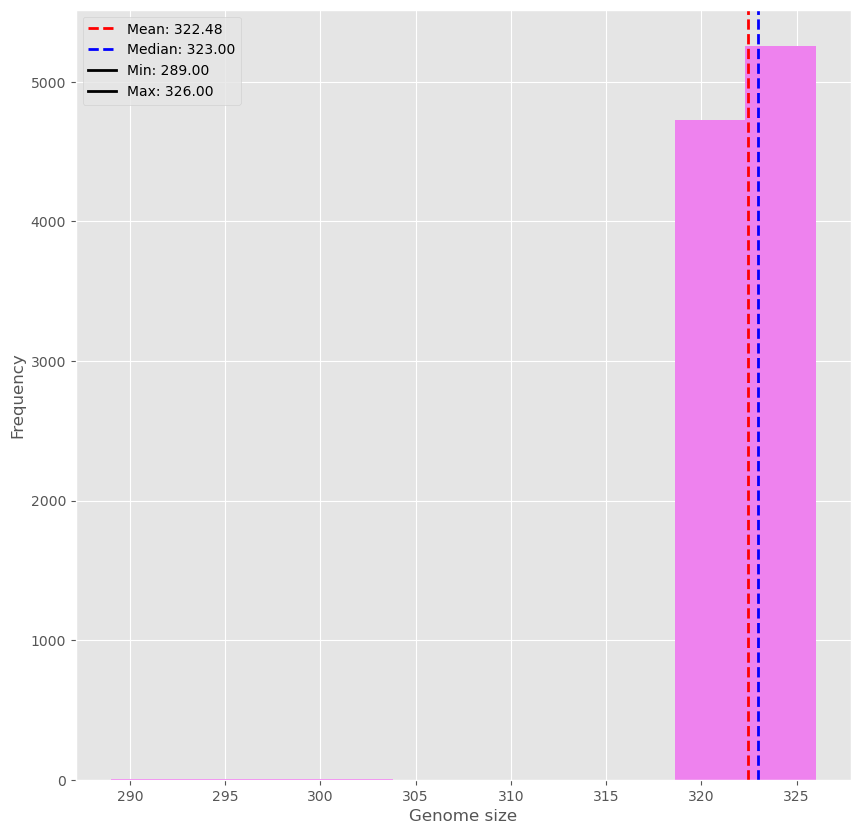

In [86]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_9_final_dataset_enhanced.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

## Exploring ways to minimise genome size

just ran a test model with random initial parameters to see how it woudl perform with a new loss (gene abundance) included. L1 regularisation applied to the fetures in the model. one note: the new loss gama and beta params: 
beta_start = 0.1
beta_end = 1.0
gamma_start = 1.0
gamma_end = 0.1

In [87]:
# Load trained model
input_dim = 55039
hidden_dim = 512
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/Desktop/3_bigdataset_newloss/3_bigdataset_newloss/8_new_loss/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.00614456e-02 9.94452603e-06 6.77055868e-05 ... 4.85130382e-04
  4.89271712e-04 2.63637950e-04]
 [1.47122529e-03 9.90423025e-04 1.13406043e-06 ... 1.48531635e-05
  1.48890567e-05 1.21369558e-05]
 [5.16757695e-03 7.21193268e-04 6.71262897e-05 ... 6.37917765e-05
  6.65683256e-05 6.89389635e-05]
 ...
 [1.93760754e-03 3.89532739e-04 2.85911779e-06 ... 6.76031414e-05
  6.73816103e-05 8.04846641e-05]
 [4.12211230e-05 3.78146033e-05 5.83417605e-05 ... 1.77437105e-05
  1.75761888e-05 1.58492894e-05]
 [3.16787884e-03 4.72447791e-05 2.31342739e-03 ... 7.37255759e-05
  7.43331038e-05 1.14726645e-04]]


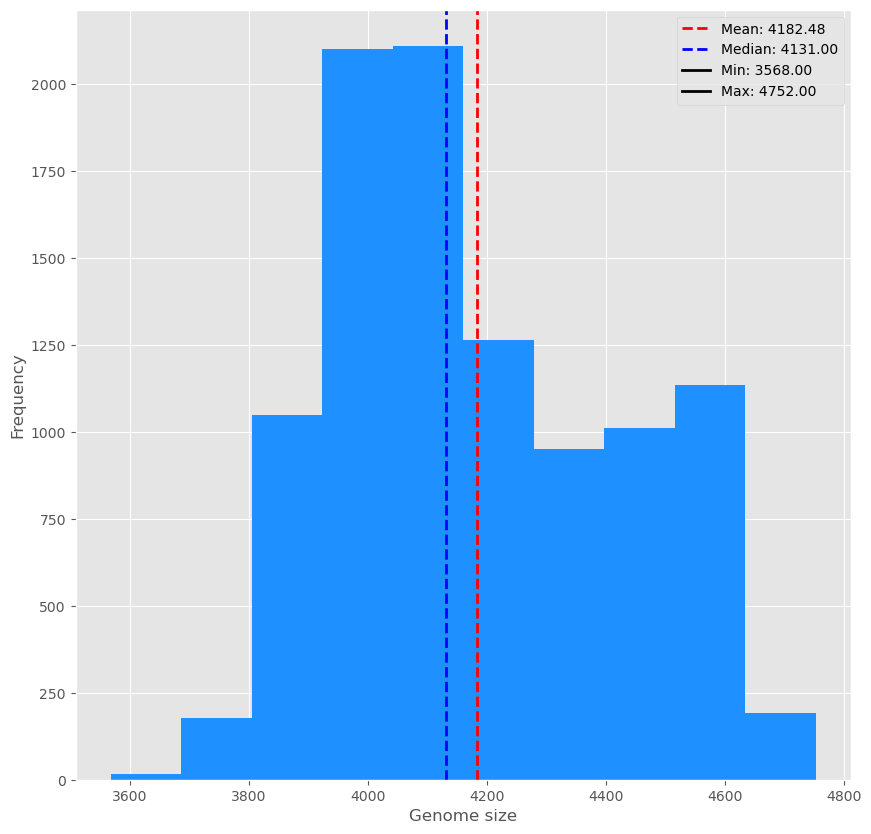

In [88]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [89]:
binary_generated_samples.sum(axis=1).min()

3568.0

In [90]:
np.mean(binary_generated_samples.sum(axis=1))

4182.4838

In [91]:
np.median(binary_generated_samples.sum(axis=1))

4131.0

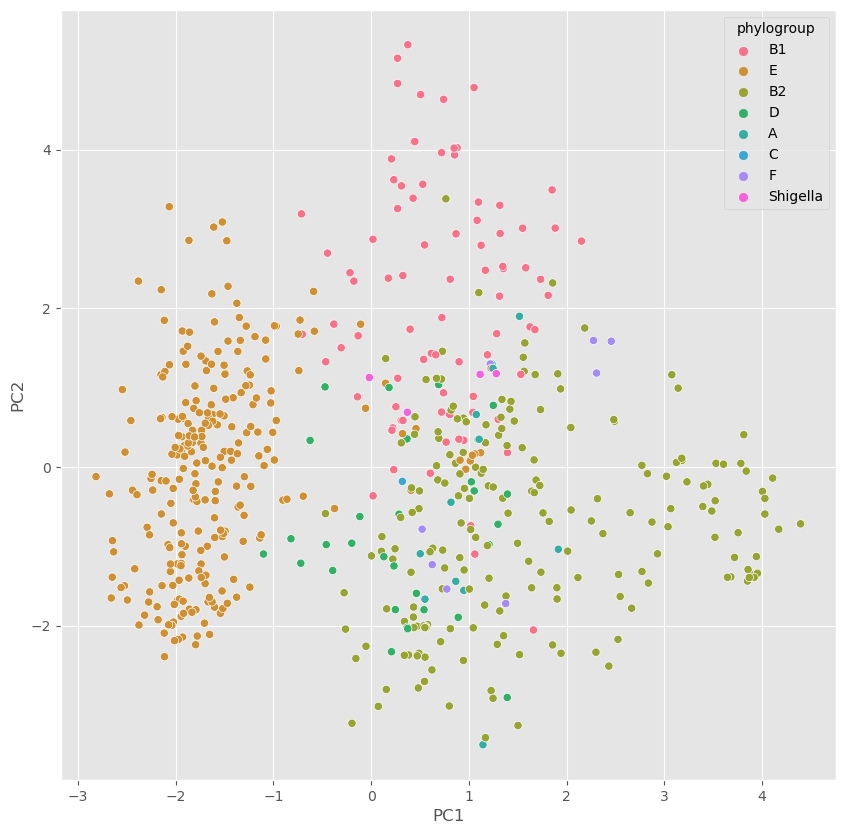

In [92]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [93]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

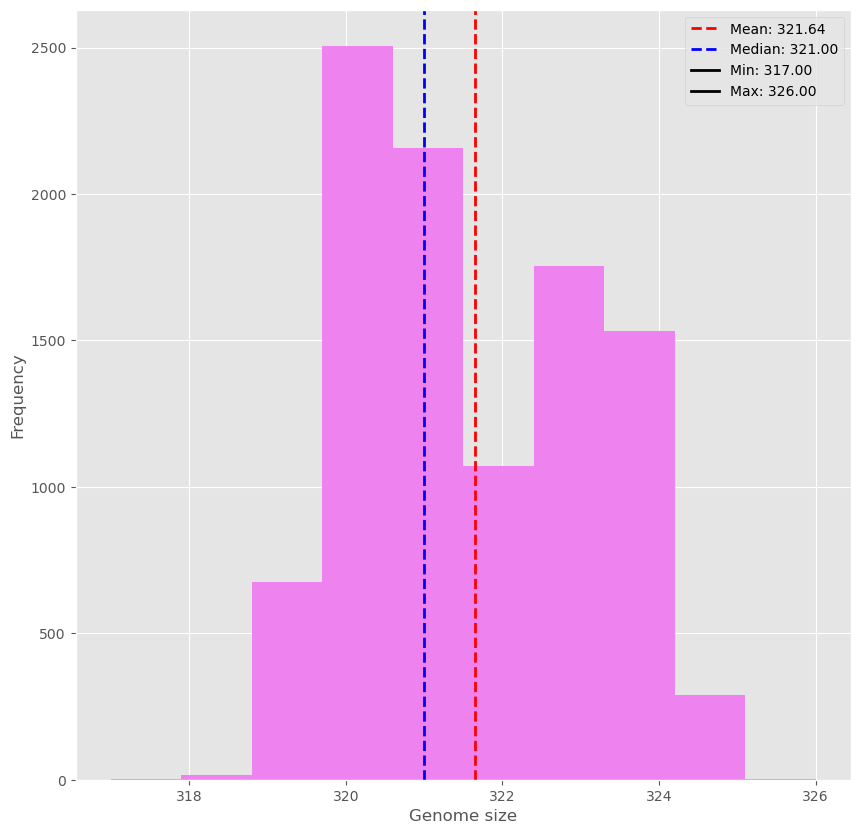

In [96]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

---------

In [97]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/Desktop/3_bigdataset_newloss/3_bigdataset_newloss/8_new_loss_enhanced_model/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[6.2400242e-05 6.5904524e-06 4.7539899e-05 ... 3.0087655e-05
  3.1055148e-05 2.3570730e-05]
 [1.2998424e-02 2.6561014e-04 1.2645693e-02 ... 5.7296002e-05
  5.7245918e-05 5.6482633e-05]
 [1.0394494e-01 1.8070199e-05 1.6111500e-05 ... 5.1702329e-05
  5.2864743e-05 3.7793980e-05]
 ...
 [6.4449772e-02 1.6898081e-04 9.3723694e-04 ... 4.9480743e-05
  5.0353268e-05 4.5907931e-05]
 [2.7765110e-04 2.5597154e-05 4.8561951e-06 ... 5.2077958e-05
  5.1975956e-05 3.9977898e-05]
 [1.1609069e-04 8.3007708e-06 6.7607005e-05 ... 2.0937521e-05
  2.0997208e-05 1.9400986e-05]]


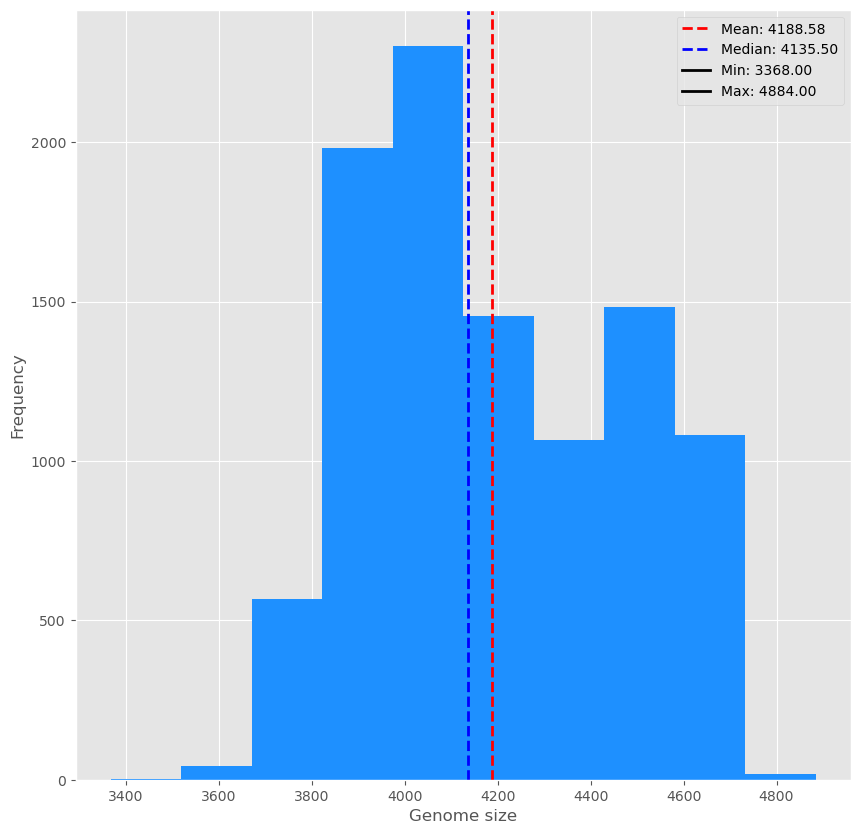

In [98]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss_enhanced_model.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [99]:
binary_generated_samples.sum(axis=1).min()

3368.0

In [100]:
np.mean(binary_generated_samples.sum(axis=1))

4188.5791

In [101]:
np.median(binary_generated_samples.sum(axis=1))

4135.5

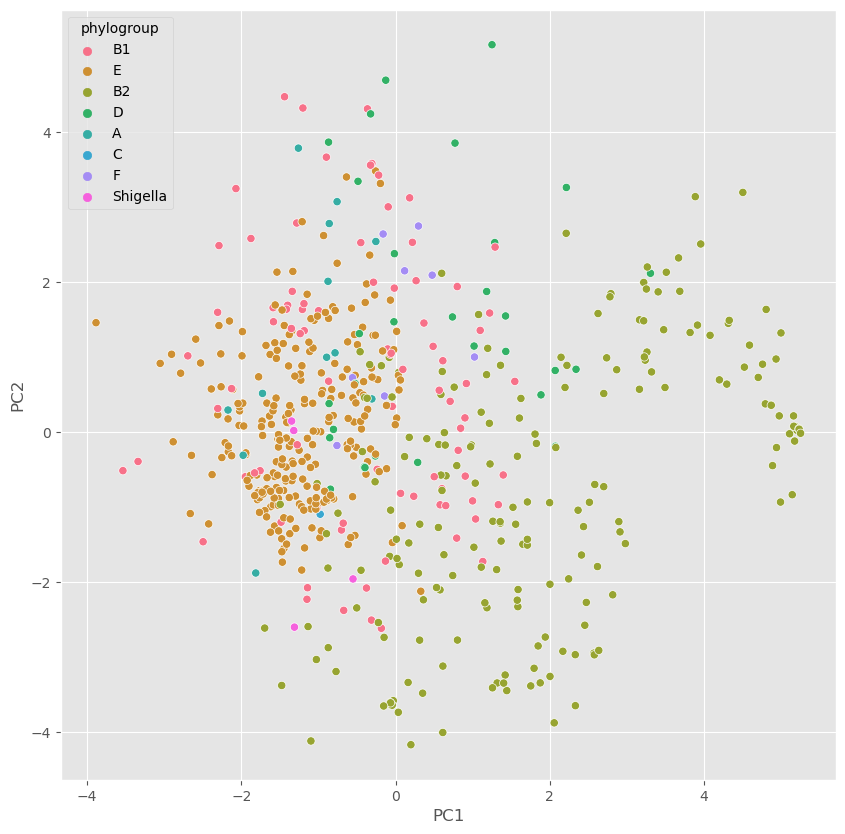

In [102]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [103]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

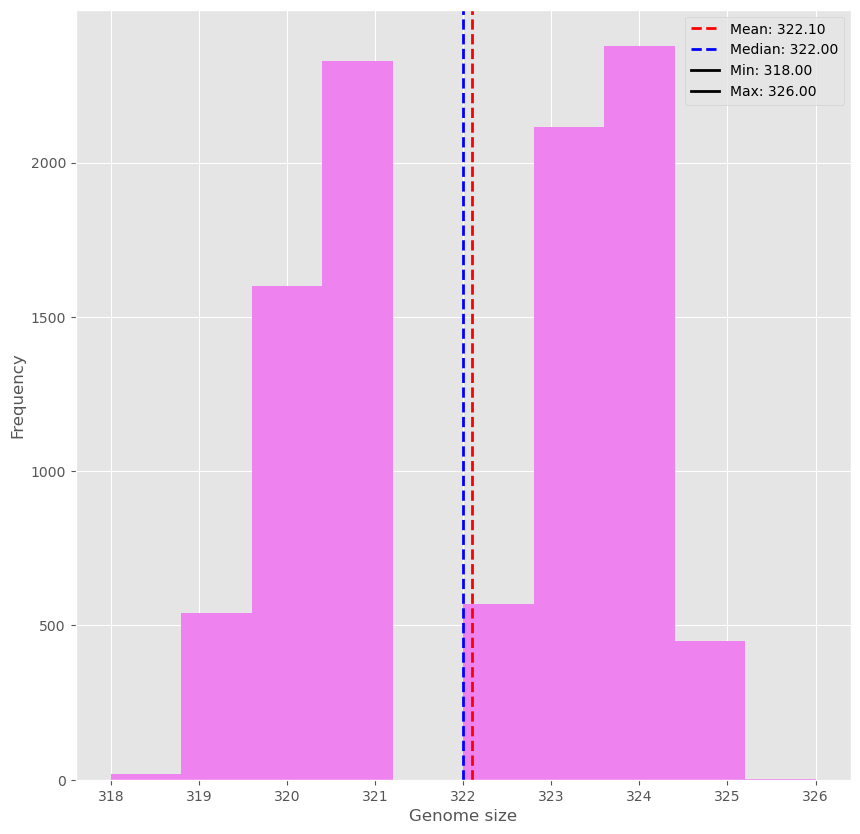

In [105]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss_enhanced_model.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

------

In [106]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/Desktop/3_bigdataset_newloss/3_bigdataset_newloss/11_non_linear_annealing/saved_KL_annealing_VAE_BD.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[5.11350936e-06 3.07370124e-06 1.47682920e-04 ... 3.68649708e-05
  3.31555202e-05 4.01793186e-05]
 [2.92789675e-02 7.30627144e-05 2.19269368e-05 ... 1.60139432e-04
  1.65801161e-04 2.26011398e-04]
 [2.99777515e-04 3.38092854e-04 2.85483056e-05 ... 9.34318450e-05
  9.43754640e-05 6.42982632e-05]
 ...
 [1.10806264e-04 2.93010853e-05 4.24174402e-08 ... 4.62057738e-04
  4.91699146e-04 1.80300631e-04]
 [4.55116133e-05 5.85721340e-04 3.88397075e-06 ... 2.37529639e-05
  2.38222219e-05 3.06716138e-05]
 [1.17580540e-01 2.63335612e-02 1.22673766e-04 ... 1.37903466e-04
  1.44963386e-04 3.60763661e-04]]


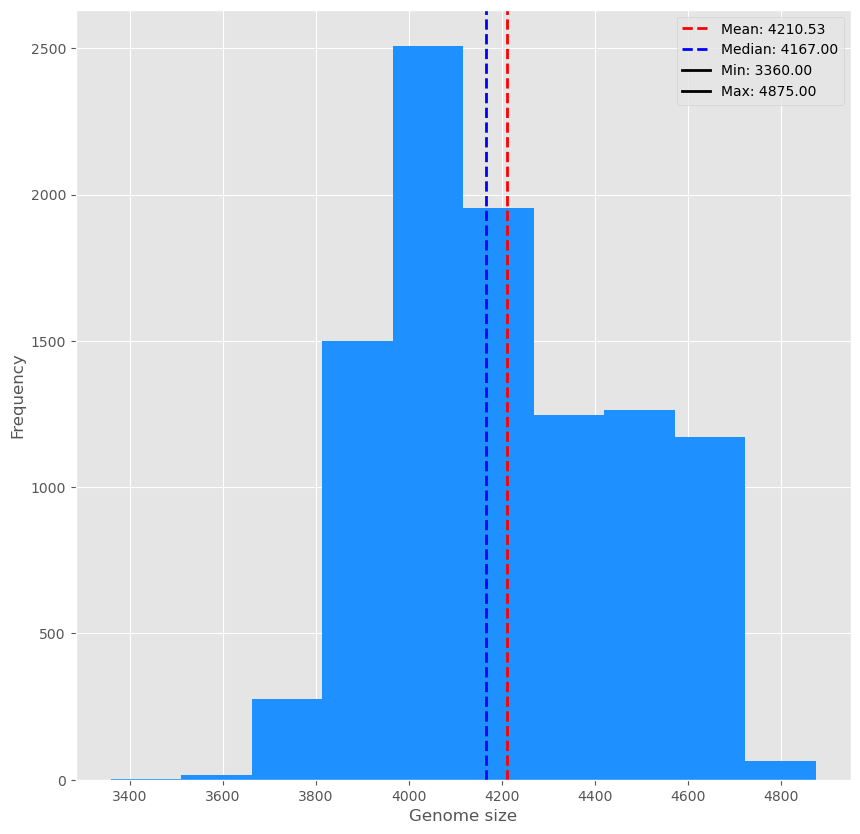

In [107]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_11_non_linear_annealing.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [108]:
binary_generated_samples.sum(axis=1).min()

3360.0

In [109]:
np.mean(binary_generated_samples.sum(axis=1))

4210.5329

In [110]:
np.median(binary_generated_samples.sum(axis=1))

4167.0

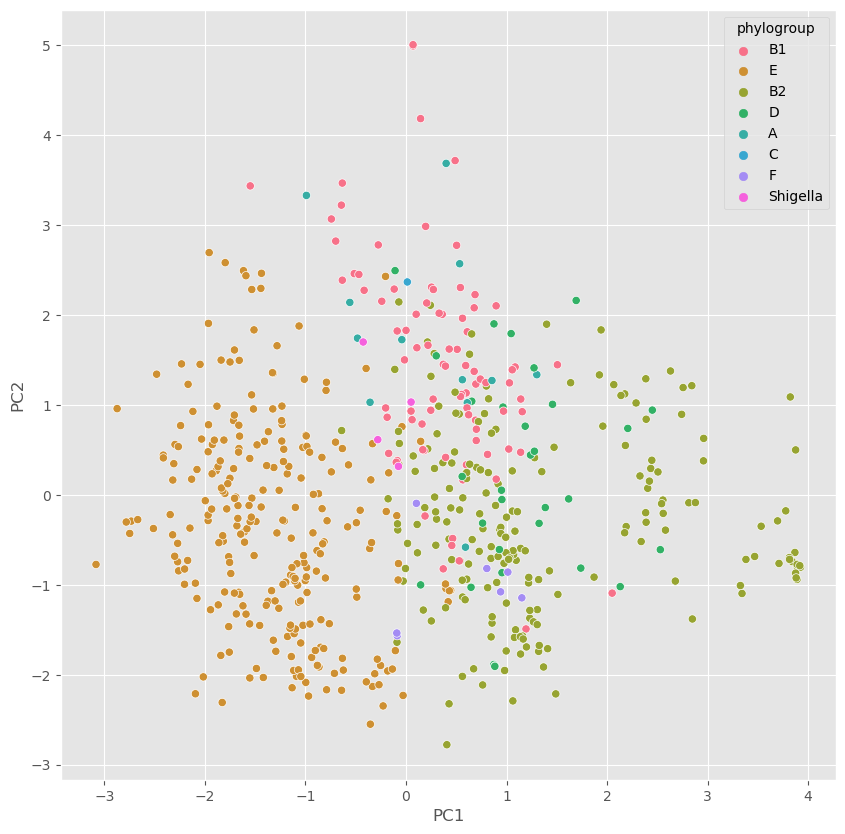

In [111]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [112]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

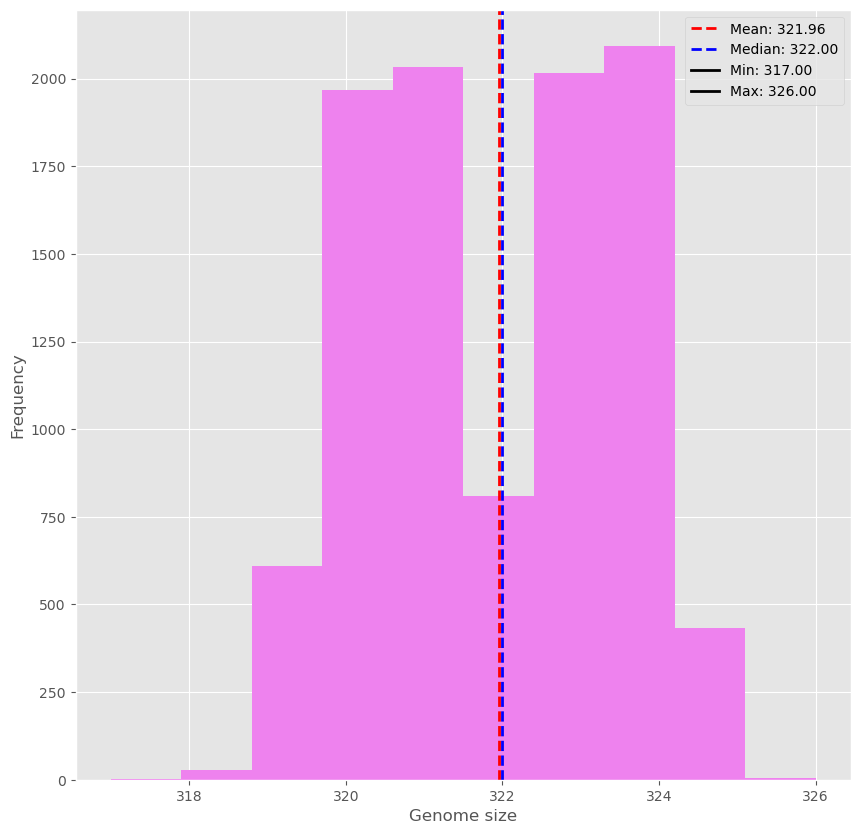

In [113]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_11_non_linear_annealing.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

_______

In [114]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/Desktop/3_bigdataset_newloss/3_bigdataset_newloss/13_add_genome_size/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[2.82055058e-04 5.79703425e-04 1.50874606e-03 ... 7.98748297e-05
  8.16161628e-05 1.02821716e-04]
 [1.25753996e-03 2.70360979e-05 9.10142080e-06 ... 1.04729763e-04
  1.03667997e-04 8.33304293e-05]
 [6.20642240e-05 5.61976913e-06 5.26712165e-06 ... 1.81345222e-05
  1.80743518e-05 1.68606384e-05]
 ...
 [2.37235028e-04 4.07465326e-04 3.49942828e-04 ... 1.50697642e-05
  1.50493424e-05 1.13354017e-05]
 [1.13806121e-01 2.24747259e-06 2.56170752e-04 ... 8.82487075e-05
  8.75679398e-05 7.31905311e-05]
 [4.54940397e-04 2.54160368e-05 4.48381208e-04 ... 4.74005719e-06
  4.51183723e-06 3.14132631e-05]]


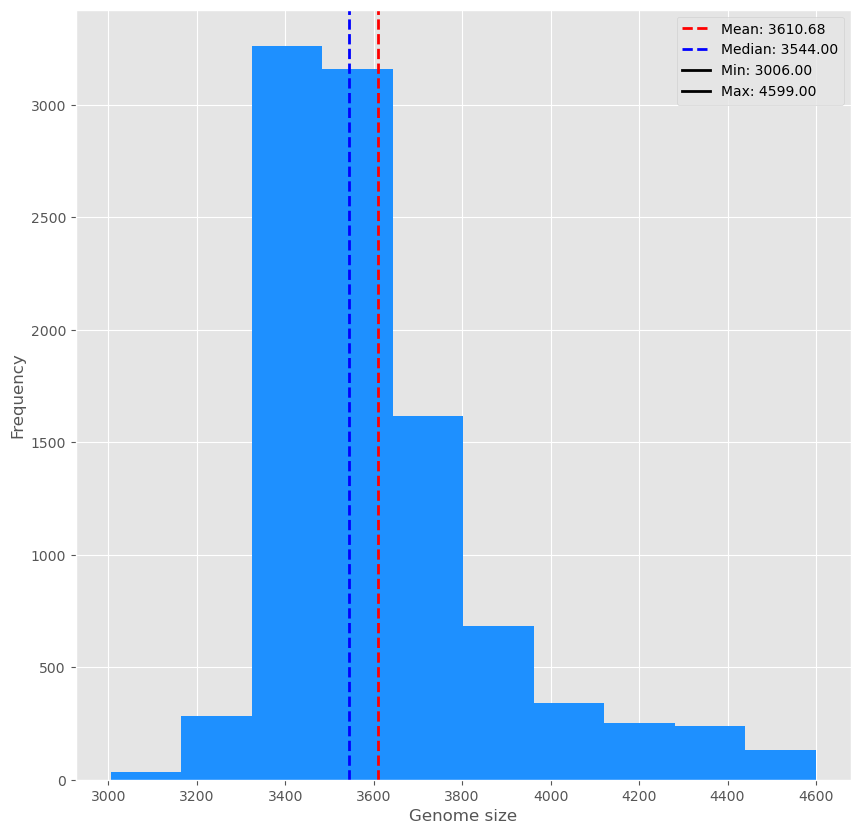

In [115]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_13_add_genome_size.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [116]:
binary_generated_samples.sum(axis=1).min()

3006.0

In [117]:
np.mean(binary_generated_samples.sum(axis=1))

3610.6814

In [118]:
np.median(binary_generated_samples.sum(axis=1))

3544.0

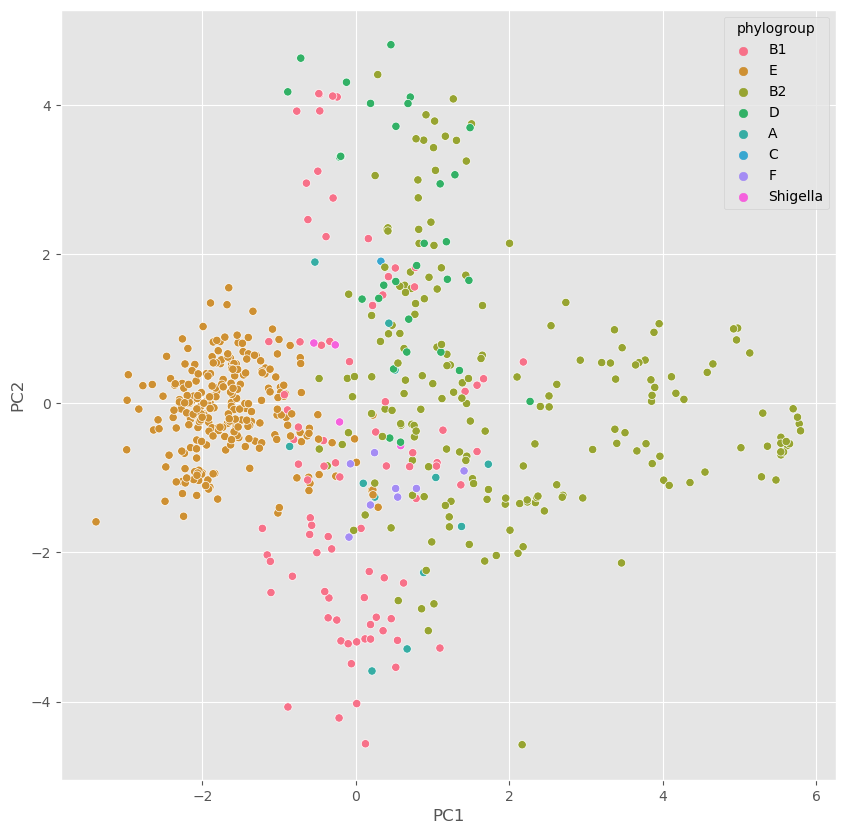

In [119]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [120]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

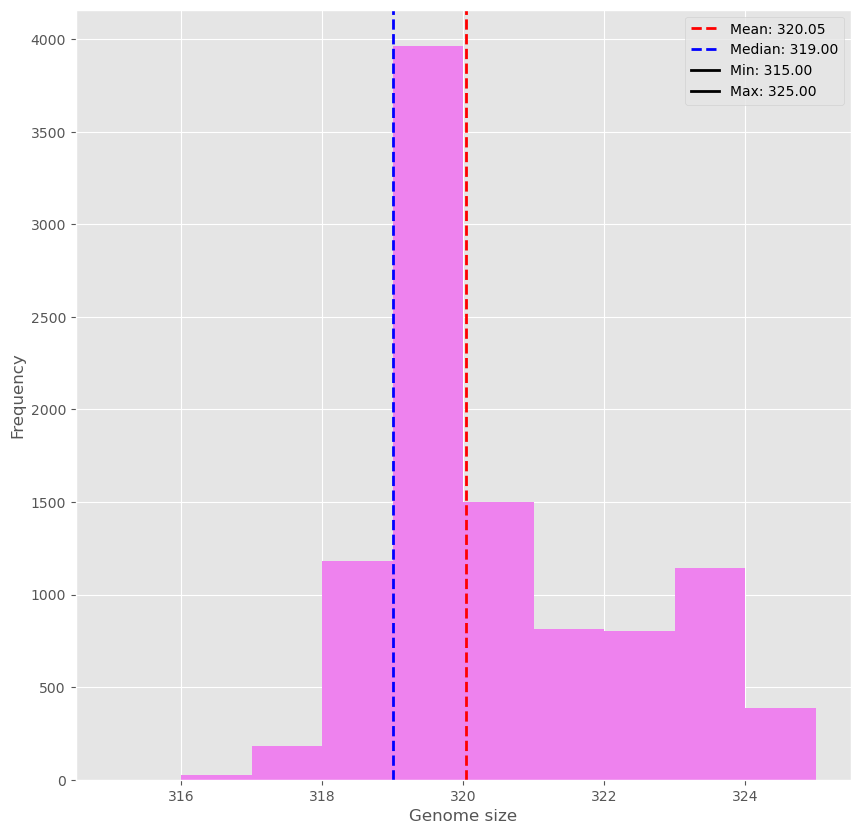

In [121]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_13_add_genome_size.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

______

In [122]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/Desktop/3_bigdataset_newloss/3_bigdataset_newloss/14_genome_size_and_cyclic_annealing/saved_KL_annealing_VAE_BD.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.7847448e-03 2.0793364e-04 2.8525898e-07 ... 4.2084481e-05
  4.3854314e-05 4.7343641e-05]
 [1.3551752e-03 4.7042871e-05 1.0134850e-04 ... 2.7238215e-05
  2.7840504e-05 2.5565683e-05]
 [2.9250007e-04 5.3335352e-06 2.3280671e-05 ... 7.1474198e-05
  6.8589325e-05 7.7884921e-05]
 ...
 [3.7561760e-05 6.5998491e-03 2.0742320e-05 ... 7.6654200e-05
  8.2518090e-05 1.2259951e-04]
 [6.2265368e-05 2.6358170e-05 4.4875709e-05 ... 2.2127182e-04
  2.0352514e-04 1.2095236e-04]
 [2.9293933e-05 1.8997102e-04 3.6753036e-06 ... 1.9326326e-05
  2.0188618e-05 2.7156257e-05]]


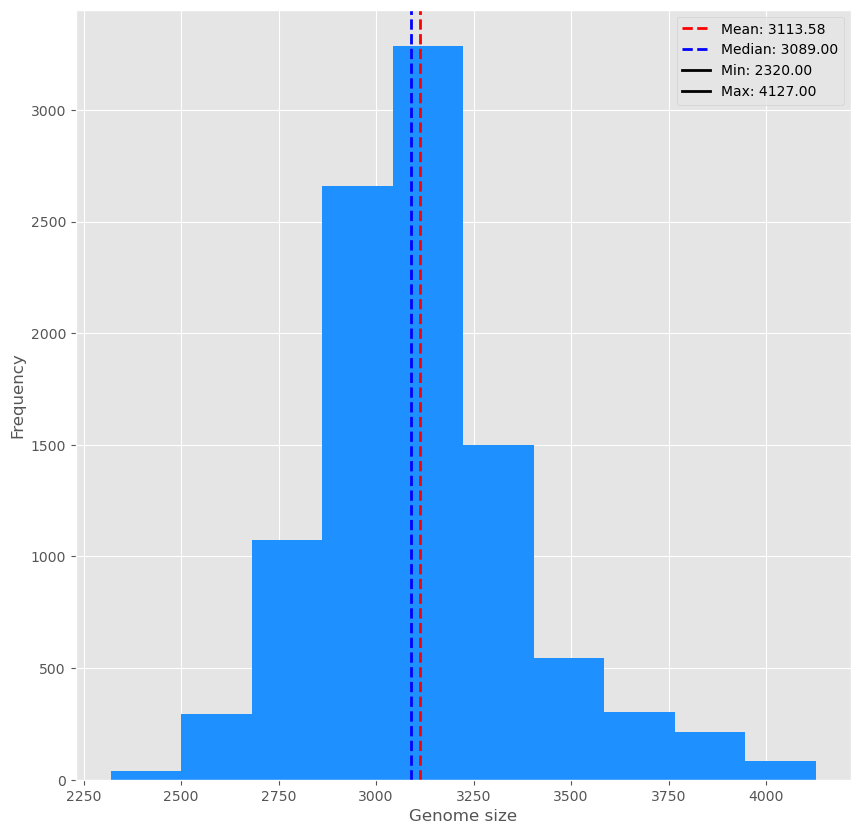

In [123]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_14_genome_size_and_cyclic_annealing.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [124]:
binary_generated_samples.sum(axis=1).min()

2320.0

In [125]:
np.mean(binary_generated_samples.sum(axis=1))

3113.5789

In [126]:
np.median(binary_generated_samples.sum(axis=1))

3089.0

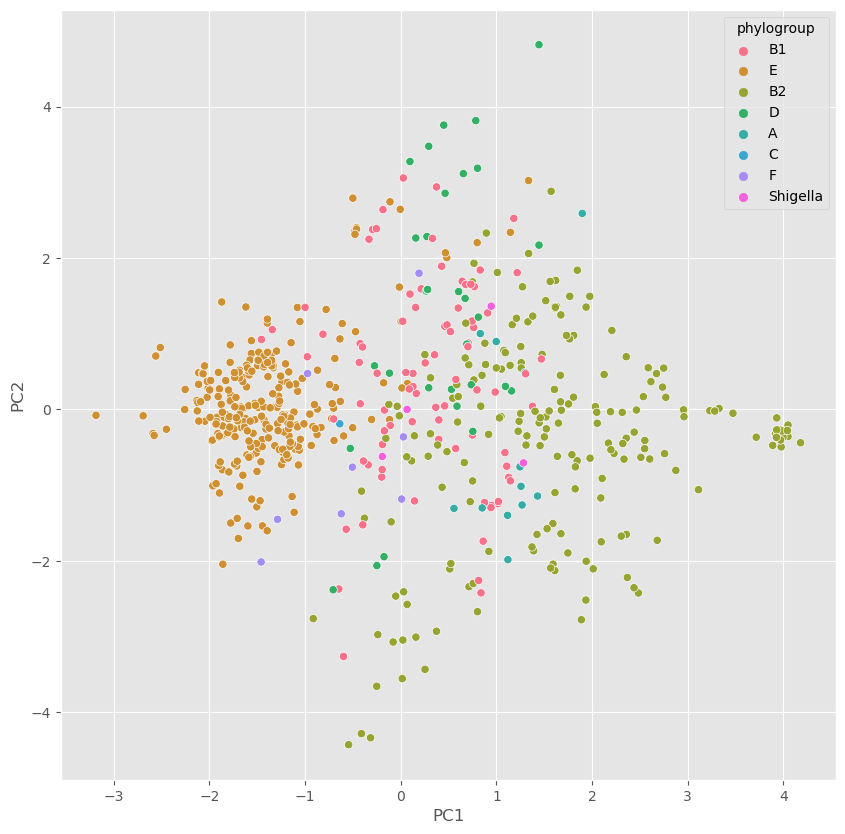

In [127]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [128]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

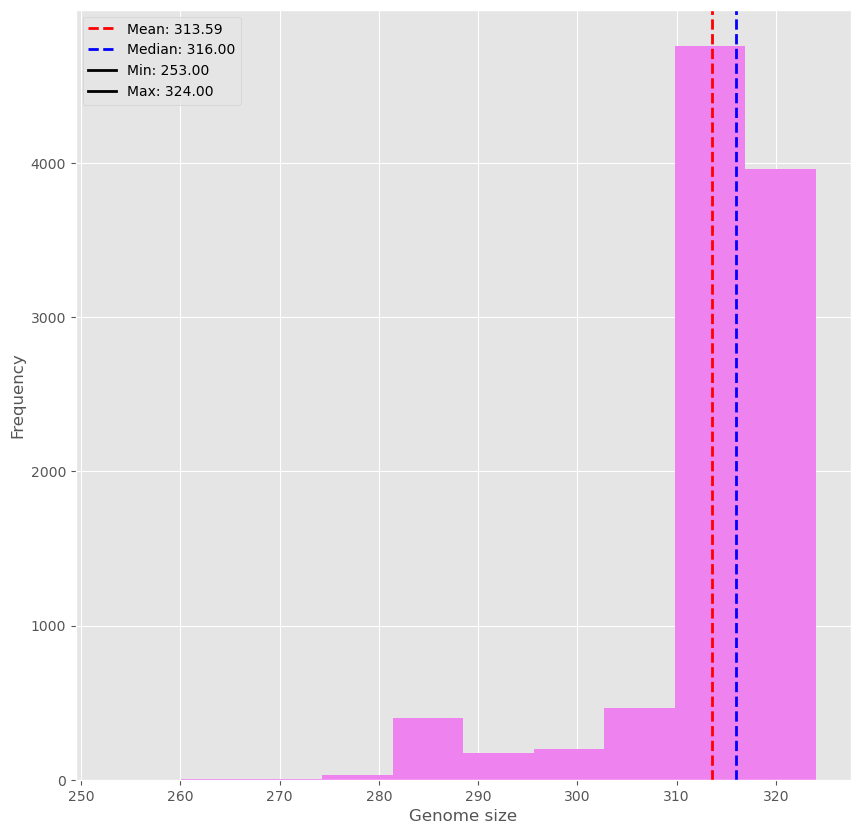

In [129]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_14_genome_size_and_cyclic_annealing.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

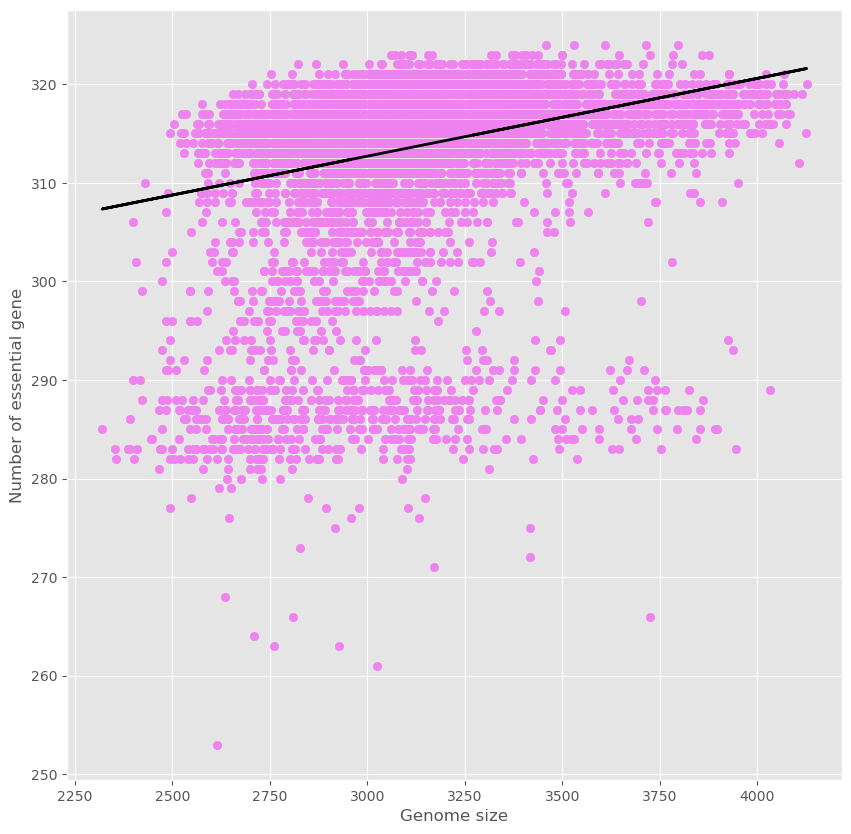

In [130]:
plt.figure(figsize=(10,10))
plt.scatter(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(binary_generated_samples.sum(axis=1), trendline(binary_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Genome size') 
plt.ylabel('Number of essential gene')
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/GS_EG_14_genome_size_and_cyclic_annealing.pdf", format="pdf", bbox_inches="tight")

-----------

In [131]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/Desktop/15_genome_size_and_cyclic_annealing_SCALED/saved_KL_annealing_VAE_BD.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.36997420e-04 6.25535977e-05 4.12695808e-05 ... 1.66132537e-04
  1.61291828e-04 1.15799245e-04]
 [9.42887180e-03 4.32940462e-04 2.11098250e-05 ... 9.39684905e-05
  9.97383904e-05 1.10680390e-04]
 [1.69736100e-03 3.38875398e-04 3.52184143e-05 ... 3.10288888e-05
  2.97388342e-05 4.38654824e-05]
 ...
 [1.39280082e-05 8.27319236e-05 2.40244262e-05 ... 1.78410090e-03
  1.69891643e-03 2.24098656e-03]
 [5.58925755e-02 1.10028707e-03 2.17993170e-06 ... 1.14386479e-04
  1.10423171e-04 1.67609265e-04]
 [1.05256299e-02 2.55612372e-06 2.05560518e-05 ... 2.20030561e-04
  2.30701087e-04 1.58884024e-04]]


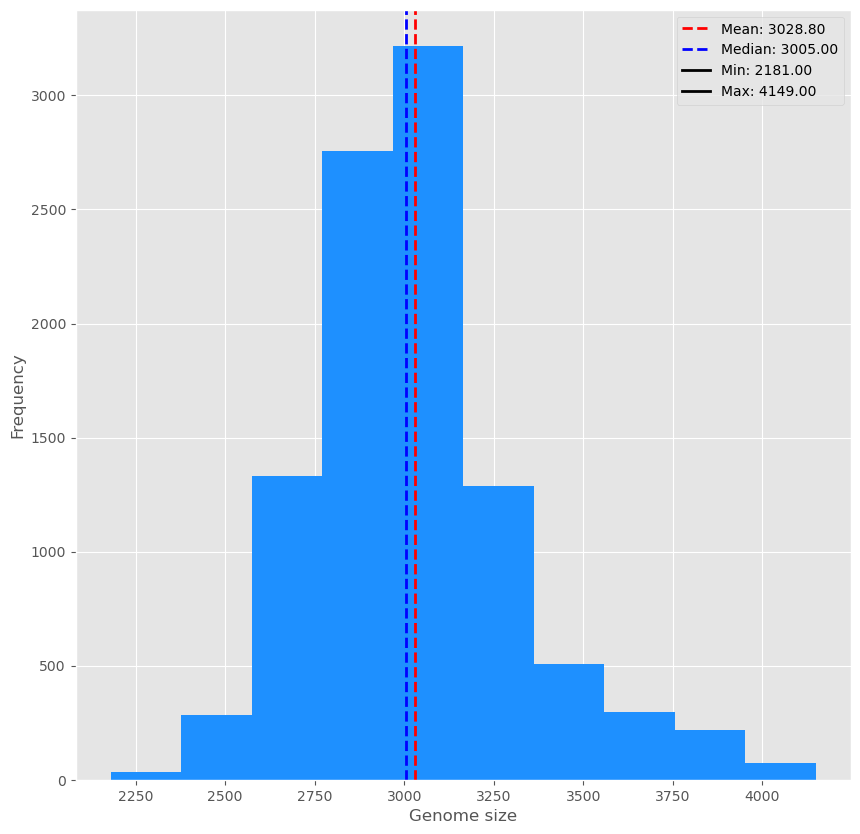

In [132]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [133]:
binary_generated_samples.sum(axis=1).min()

2181.0

In [134]:
np.mean(binary_generated_samples.sum(axis=1))

3028.7985

In [135]:
np.median(binary_generated_samples.sum(axis=1))

3005.0

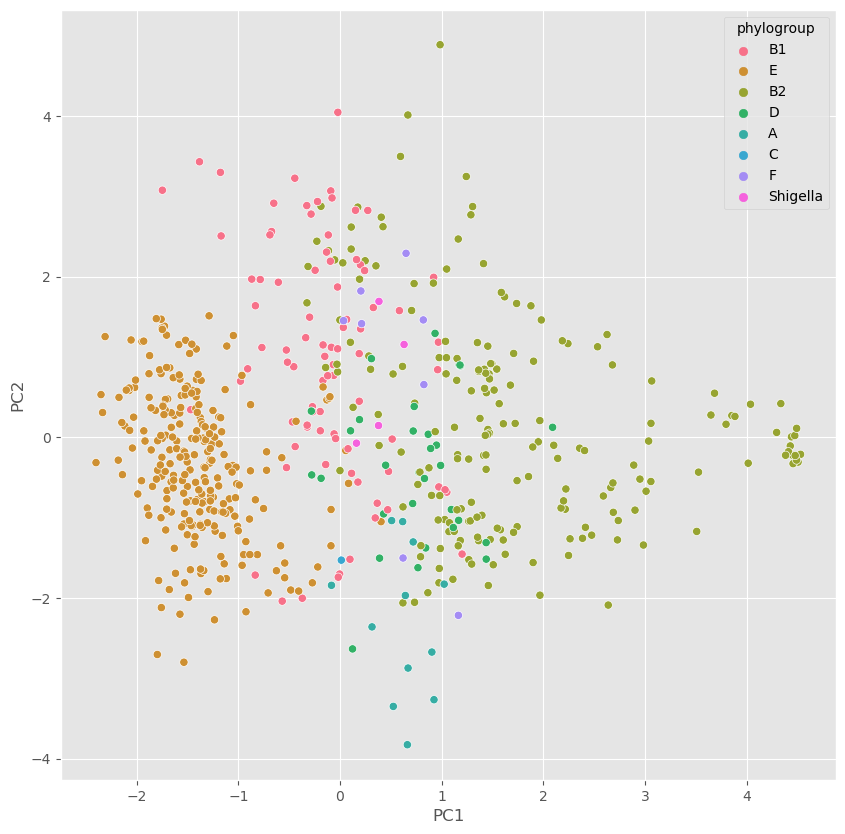

In [136]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
# plt.savefig("figures/pca_latent_space_visualisation_full_dataset_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [137]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

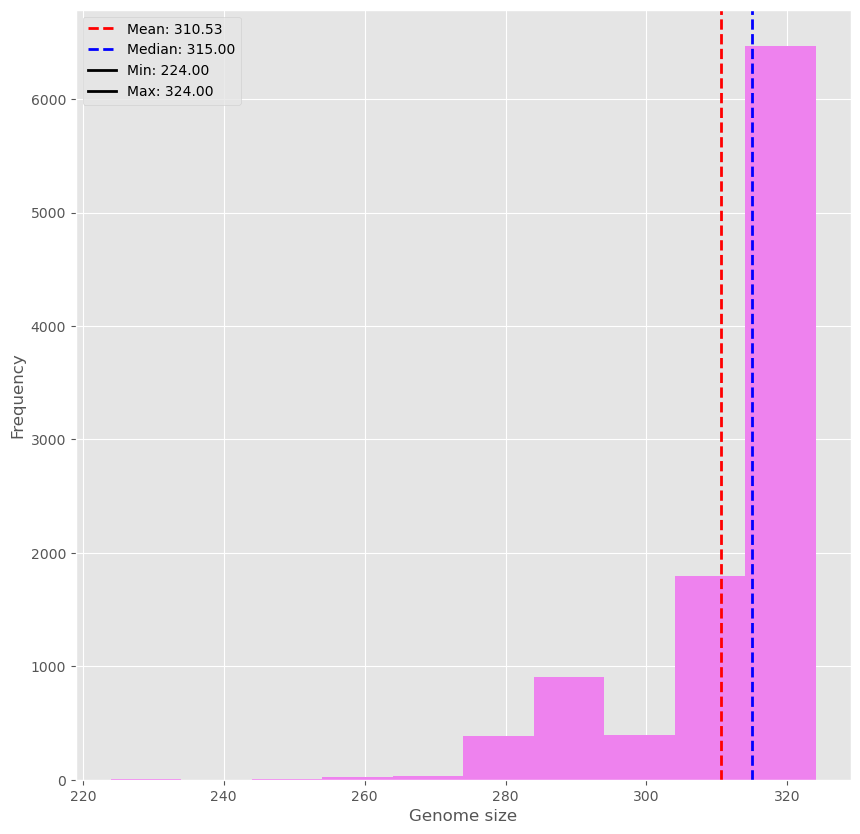

In [138]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

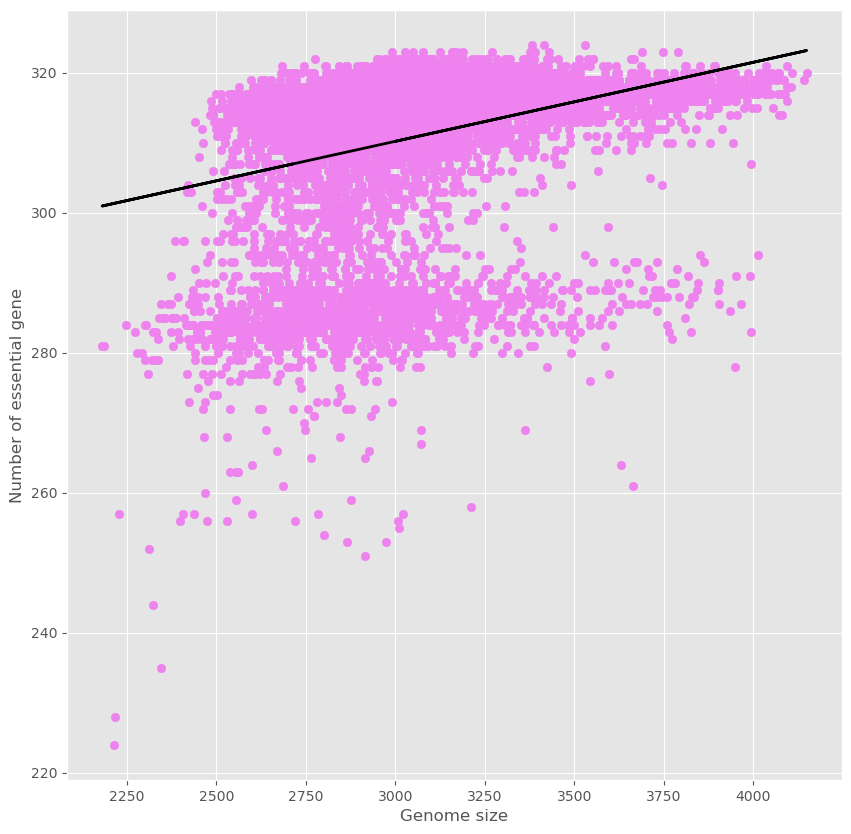

In [139]:
plt.figure(figsize=(10,10))
plt.scatter(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(binary_generated_samples.sum(axis=1), trendline(binary_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Genome size') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

In [141]:
# Generate 10 new samples
num_samples = 10000
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim)  # Sample from the standard normal distribution because the latent space follows normal distribution 
    generated_samples = model.decode(z).cpu().numpy() 

threshold = 0.5
binary_generated_samples = (generated_samples > threshold).astype(float)

print("Generated samples (binary):\n", binary_generated_samples)
print("\n")
print("Generated samples (sigmoid function output):\n", generated_samples)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.6305754e-01 5.7755534e-07 4.1901790e-06 ... 7.8279256e-05
  7.8445220e-05 7.3615272e-05]
 [5.1114435e-05 7.4276648e-04 4.4849316e-05 ... 1.5936332e-05
  1.6095008e-05 2.5634357e-05]
 [4.0958347e-03 8.5760321e-06 1.5145938e-05 ... 3.1058404e-05
  3.1603104e-05 3.1901454e-05]
 ...
 [5.7546017e-03 5.6137353e-05 2.1920046e-02 ... 2.7958129e-05
  2.9584504e-05 2.4219775e-05]
 [3.1947706e-02 3.3249118e-05 6.6322414e-06 ... 5.0288357e-04
  4.6647017e-04 5.1926525e-04]
 [9.4180537e-04 5.7641037e-06 2.5643871e-05 ... 8.7518019e-05
  9.0961083e-05 8.0501093e-05]]


In [142]:
total_ones = np.sum(binary_generated_samples, axis=1)
min_ones_index = np.argmin(total_ones)

latent_distances = np.linalg.norm(generated_samples - generated_samples[min_ones_index], axis=1)

closest_latent_index = np.argmin(latent_distances)

print(f"Closest latent vector (z): {z[closest_latent_index]}")
print(f"Generated sample from closest latent vector:\n {generated_samples[closest_latent_index]}")

Closest latent vector (z): tensor([-1.1488,  0.1597,  0.2198,  0.7308,  1.7787, -0.4728, -0.5731,  0.3891,
        -1.2389,  1.9307,  0.9329,  0.2948, -0.3724, -0.2076, -3.2779, -0.4828,
         0.0394,  0.6845, -0.3987, -3.0498,  2.5841, -0.7652, -0.2289, -0.4252,
        -0.2935, -0.7748, -0.3673,  0.2215,  0.2710,  0.9312,  1.1557,  1.4759])
Generated sample from closest latent vector:
 [7.5982542e-05 3.7613968e-04 1.4439074e-04 ... 1.1541777e-03 1.1015639e-03
 1.8401326e-03]


In [143]:
sum(binary_generated_samples[min_ones_index])

1994.0

In [144]:
latent_distances

array([ 8.597734 ,  9.611058 ,  7.2899146, ..., 10.249985 ,  8.856772 ,
       12.623146 ], dtype=float32)

In [145]:
z_of_interest = z[closest_latent_index] 
z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)  

noise_std = 0.1

num_additional_samples = 10000  
with torch.no_grad():
    noise = torch.randn(num_additional_samples, latent_dim) * noise_std
    z_samples = z_of_interest_tensor + noise
    additional_generated_samples = model.decode(z_samples).cpu().numpy()


print("Additional generated samples:")
print(additional_generated_samples)

/var/folders/nx/hnfjrvz145n2_hzn95z65pmc0000gn/T/ipykernel_2703/2647228576.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)


Additional generated samples:
[[6.0774550e-05 4.0143111e-04 1.7136030e-04 ... 9.2776062e-04
  8.9136662e-04 1.5509046e-03]
 [2.5467161e-04 3.2393332e-04 1.5152778e-04 ... 1.0921879e-03
  1.0522007e-03 1.8093858e-03]
 [9.2148322e-05 3.4141645e-04 1.7457131e-04 ... 1.1287385e-03
  1.0741983e-03 1.8131920e-03]
 ...
 [8.3787723e-05 4.0338561e-04 1.4272619e-04 ... 1.2894744e-03
  1.2295230e-03 2.2334270e-03]
 [7.3446987e-05 3.6774587e-04 1.3490141e-04 ... 1.0337613e-03
  9.8598900e-04 1.6841326e-03]
 [1.8286670e-04 3.3781902e-04 1.2903013e-04 ... 1.2026781e-03
  1.1446375e-03 1.8308947e-03]]


In [146]:
threshold = 0.5
additional_generated_samples = (additional_generated_samples > threshold).astype(float)

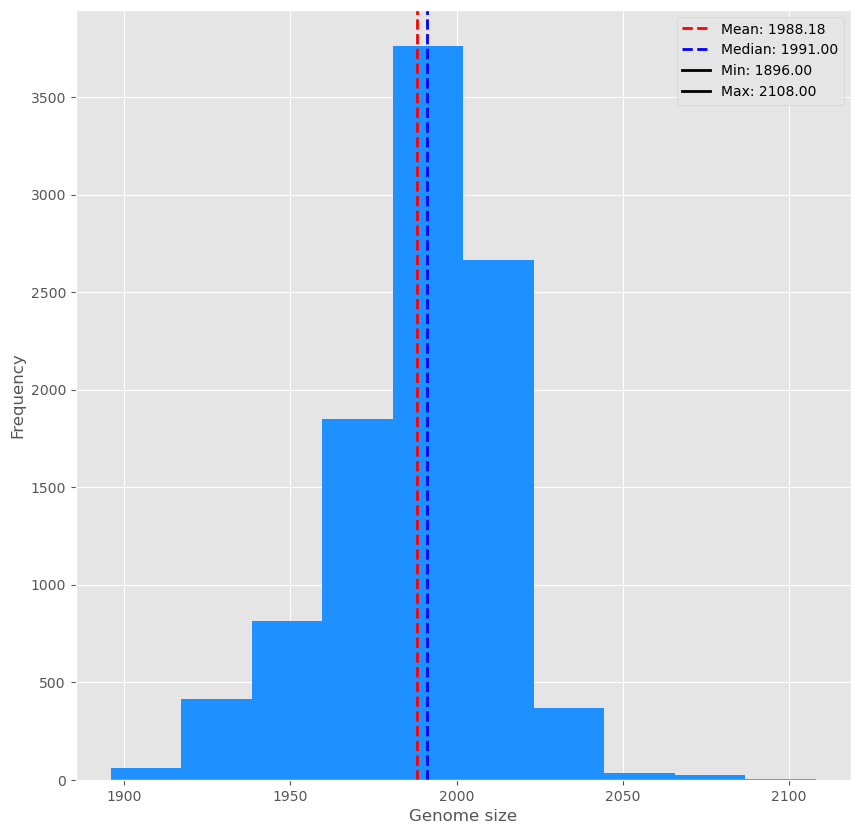

In [147]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(additional_generated_samples, figure_name, plot_color)


In [148]:
essential_gene_positions

{'rpsT': [15341],
 'ribF': [15340],
 'ileS': [15339],
 'lspA': [15338, 36962, 42383],
 'ispH': [15336],
 'dapB': [15334, 40591],
 'folA': [1511, 15316],
 'lptD': [15308],
 'ftsL': [15283],
 'ftsI': [15282, 40806],
 'murE': [15281, 40807],
 'murF': [15280, 33264, 33265, 40809],
 'mraY': [15279, 40810],
 'murD': [15278, 33262, 33263],
 'ftsW': [15277],
 'murG': [15276],
 'murC': [15275],
 'ftsQ': [15273],
 'ftsA': [15272],
 'ftsZ': [15271],
 'lpxC': [15270],
 'secA': [15268],
 'coaE': [11933],
 'aceF': [11944],
 'lpd': [19570],
 'can': [11956],
 'hemL': [11985, 42003],
 'erpA': [11987, 37359],
 'dapD': [11996],
 'map': [11998, 39912],
 'rpsB': [11999],
 'tsf': [12000, 48412],
 'pyrH': [12001],
 'frr': [12002],
 'dxr': [12003],
 'cdsA': [12006, 12100, 29339, 30377, 34707],
 'bamA': [12008],
 'lpxD': [12010, 46997],
 'fabZ': [12011],
 'lpxA': [12012],
 'lpxB': [12013],
 'dnaE': [9123, 12015, 18059, 23498, 31303, 41020, 50504],
 'accA': [12016, 40738],
 'tilS': [12019, 40737],
 'proS': [164

In [149]:
additional_generated_samples.sum(axis=1)

array([1984., 1931., 1989., ..., 1979., 2002., 1939.])

In [150]:
additional_generated_samples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [155]:
essential_genes_count_per_sample = count_essential_genes(additional_generated_samples, essential_gene_positions)

In [157]:
essential_genes_count_per_sample

array([234, 233, 234, ..., 234, 235, 233])

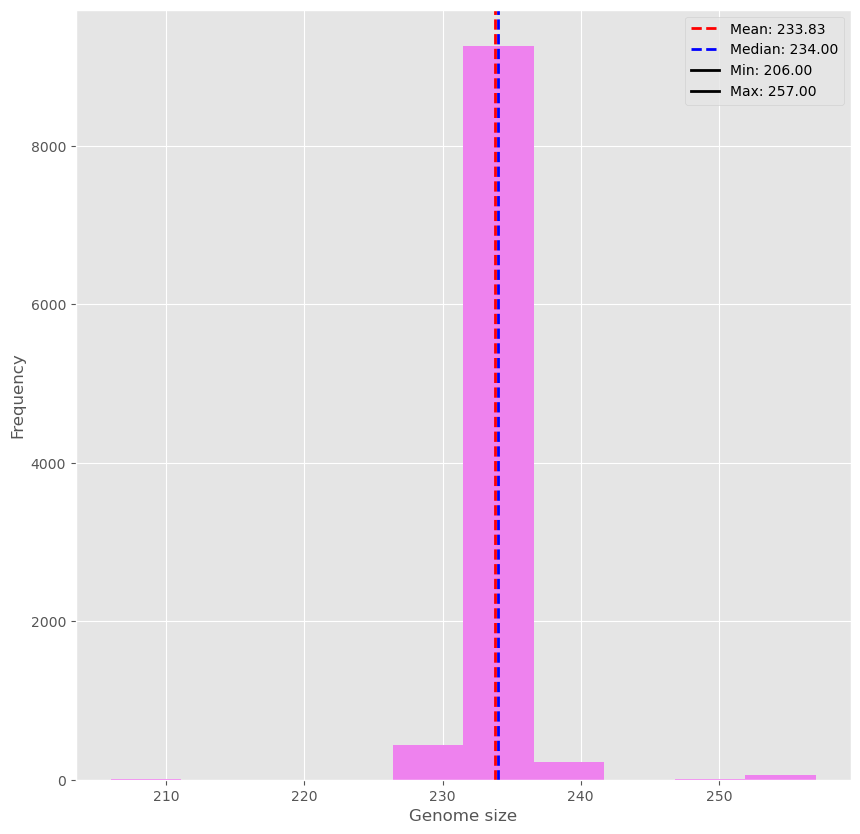

In [158]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additioinal_essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

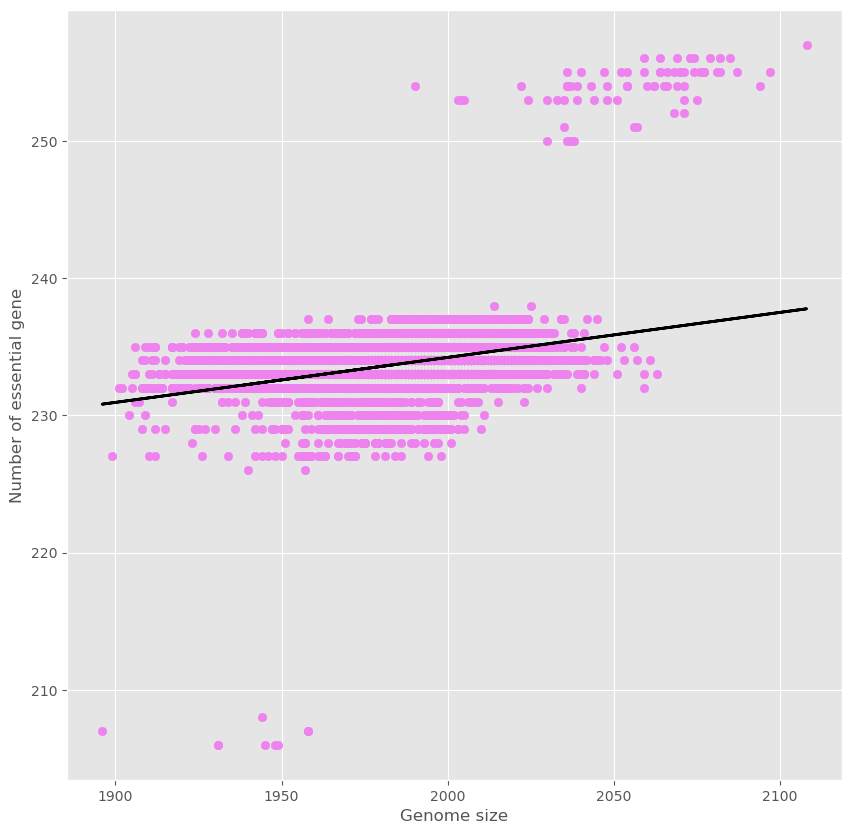

In [159]:
plt.figure(figsize=(10,10))
plt.scatter(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(additional_generated_samples.sum(axis=1), trendline(additional_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Genome size') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

---------

In [160]:
essential_genes_count_per_sample.max()

257

In [161]:
np.where(essential_genes_count_per_sample == 300)

(array([], dtype=int64),)

In [162]:
additional_generated_samples[3551]

array([0., 0., 0., ..., 0., 0., 0.])

In [163]:
present_genes = all_genes[:-1][additional_generated_samples[3551] == 1]

In [164]:
present_genes

Index(['group_2479', 'group_32', 'yigB', 'pstS1', 'emrA', 'fbaA_2', 'holB',
       'group_10368_2', 'arcC1_2', 'group_1544',
       ...
       'xcpW', 'xcpV', 'epsH', 'epsG', 'epsD_1_1', 'epsC', 'group_3026_4',
       'pppA', 'group_1927_1', 'sppA_2'],
      dtype='object', length=2004)

In [165]:
cleaned_gene_names = [extract_prefix(name) for name in present_genes]
cleaned_gene_names_2 = cleaned_gene_names
unique_gene_names = list(set(cleaned_gene_names))
cleaned_gene_names_2 += datatset_EG
unique_gene_names_2 = list(set(cleaned_gene_names_2))

In [166]:
len(unique_gene_names)

1677

In [167]:
len(unique_gene_names_2)

1769

In [168]:
unique_gene_names_2

['wecA',
 'yhhS',
 'mdtL',
 'apbC',
 'kdgR',
 'hisS',
 'gudP',
 'dctA',
 'ccmC',
 'rpsL',
 'bglB',
 'epsE',
 'rpsT',
 'appC',
 'sfsA',
 'ubiB',
 'yciH',
 'hda',
 'glnM',
 'hokC',
 'mntR',
 'narI',
 'glnD',
 'potD',
 'artM',
 'dnaN',
 'aaeX',
 'moaC',
 'rluE',
 'slmA',
 'plsB',
 'iraM',
 'panB',
 'pabC',
 'nikE',
 'ydfB',
 'exoX',
 'yheS',
 'metN',
 'atpE',
 'garK',
 'tdcE',
 'ldhA',
 'mipA',
 'trpA',
 'mhpC',
 'garP',
 'napC',
 'ubiG',
 'adhP',
 'yfcA',
 'mhpB',
 'ybdG',
 'ybhF',
 'yiaD',
 'yciN',
 'kdpC',
 'srlR',
 'uppP',
 'osmB',
 'epsD',
 'modA',
 'rpoN',
 'znuC',
 'trmO',
 'cusS',
 'ybjJ',
 'groS',
 'yebC',
 'yecM',
 'galE',
 'lysA',
 'fldB',
 'murF',
 'narK',
 'nimR',
 'pncC',
 'panZ',
 'axe1',
 'mdtJ',
 'btuF',
 'rbsD',
 'pdeK',
 'hslR',
 'ycfH',
 'gluQ',
 'uidC',
 'pyrD',
 'rsgA',
 'rng',
 'fldA',
 'ompF',
 'arcB',
 'hemG',
 'yfcG',
 'ssb',
 'rplP',
 'gph',
 'yhdJ',
 'araC',
 'gor',
 'rnd',
 'flgJ',
 'yejG',
 'mtr',
 'recA',
 'rplX',
 'rpsB',
 'rffH',
 'ycjG',
 'manY',
 'ampD',

In [169]:
np.save('/Users/anastasiiashcherbakova/git_projects/masters_project/data/unique_gene_names.npy', unique_gene_names_2)

---------

In [170]:
import pandas as pd
file_path = '/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.txt'

df = pd.read_csv(file_path, delimiter='\t')  

df.to_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv', index=False)

In [171]:
essential_genes_website = pd.read_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv')

In [172]:
essential_genes_website_array = np.array(essential_genes_website['Gene Name'])

In [173]:
essential_genes_website_array

array(['ribF', 'ileS', 'lspA', 'ispH', 'dapB', 'folA', 'lptD', 'ftsL',
       'ftsI', 'murE', 'murF', 'mraY', 'murD', 'ftsW', 'murG', 'murC',
       'ftsQ', 'ftsA', 'ftsZ', 'lpxC', 'secM', 'secA', 'coaE', 'can',
       'folK', 'hemL', 'erpA', 'dapD', 'map', 'rpsB', 'tsf', 'pyrH',
       'frr', 'dxr', 'ispU', 'cdsA', 'rseP', 'bamA', 'lpxD', 'fabZ',
       'lpxA', 'lpxB', 'dnaE', 'accA', 'tilS', 'proS', 'hemB', 'secD',
       'secF', 'ribD', 'ribE', 'nusB', 'thiL', 'dxs', 'ispA', 'ffs',
       'dnaX', 'adk', 'hemH', 'lpxH', 'cysS', 'folD', 'argU', 'mrdB',
       'mrdA', 'nadD', 'holA', 'lptE', 'leuS', 'lnt', 'leuW', 'glnS',
       'fldA', 'infA', 'ftsK', 'lolA', 'serS', 'rpsA', 'msbA', 'lpxK',
       'kdsB', 'mukF', 'mukE', 'mukB', 'asnS', 'fabA', 'serT', 'murJ',
       'rne', 'yceQ', 'fabD', 'fabG', 'acpP', 'tmk', 'holB', 'lolC',
       'lolD', 'lolE', 'mnmA', 'pth', 'prs', 'ispE', 'lolB', 'hemA',
       'prfA', 'prmC', 'kdsA', 'topA', 'ribA', 'fabI', 'tyrS', 'ribC',
       'pheT', 'phe

In [174]:
essential_genes_mask = np.isin(all_genes, essential_genes_website_array)
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [175]:
essential_genes_df

,holB,secD,coaE,can,folK,hemL,erpA,dapD,map,rpsB,...,mrdB,mrdA,nadD,holA,lptE,leuS,lnt,glnS,fldA,hemB
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [176]:
essential_genes_present_array = np.array(essential_genes_df.columns)

In [177]:
len(essential_genes_present_array)

274

In [178]:
genes_missing = list(set(essential_genes_website_array) - set(essential_genes_present_array))

In [179]:
genes_missing

['thrU',
 'metG',
 'lptB',
 'leuZ',
 'argU',
 'msbA',
 'rnpB',
 'ispU',
 'hisR',
 'serT',
 'fbaA',
 'lolD',
 'ssb',
 'trpT',
 'lptG',
 'ffs',
 'leuW',
 'fabG',
 'yceQ',
 'glyT',
 'topA',
 'dnaC',
 'yihA',
 'dfp',
 'serV',
 'proM',
 'leuU',
 'argX']

In [180]:
len(genes_missing)

28

In [181]:
matched_columns = []

for gene in genes_missing:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['metG_2_1' 'metG_2_2' 'msbA_3' 'fbaA_1' 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1'
 'lolD_3' 'lolD_3_1' 'lolD_4' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2' 'ssb_4'
 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1' 'lptG_1'
 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'fabG_1' 'fabG_3' 'fabG_1_1'
 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2' 'fabG2' 'fabG_2_3' 'topA_3'
 'topA_3_1' 'topA_3_2' 'dnaC_3' 'dnaC_1' 'dnaC_2' 'dnaC_1_1' 'dnaC_1_2'
 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5' 'dnaC_2_1' 'dnaC_1_6' 'dnaC_2_2']
49


In [182]:
missing_genes = ['ssb', 'dnaC', 'metG', 'fabG', 'lptB', 'msbA', 'fbaA', 'lolD', 'topA', 'lptG']

----------

# Comparing the two different essential genes arrays

In [183]:
essential_genes_website_array

array(['ribF', 'ileS', 'lspA', 'ispH', 'dapB', 'folA', 'lptD', 'ftsL',
       'ftsI', 'murE', 'murF', 'mraY', 'murD', 'ftsW', 'murG', 'murC',
       'ftsQ', 'ftsA', 'ftsZ', 'lpxC', 'secM', 'secA', 'coaE', 'can',
       'folK', 'hemL', 'erpA', 'dapD', 'map', 'rpsB', 'tsf', 'pyrH',
       'frr', 'dxr', 'ispU', 'cdsA', 'rseP', 'bamA', 'lpxD', 'fabZ',
       'lpxA', 'lpxB', 'dnaE', 'accA', 'tilS', 'proS', 'hemB', 'secD',
       'secF', 'ribD', 'ribE', 'nusB', 'thiL', 'dxs', 'ispA', 'ffs',
       'dnaX', 'adk', 'hemH', 'lpxH', 'cysS', 'folD', 'argU', 'mrdB',
       'mrdA', 'nadD', 'holA', 'lptE', 'leuS', 'lnt', 'leuW', 'glnS',
       'fldA', 'infA', 'ftsK', 'lolA', 'serS', 'rpsA', 'msbA', 'lpxK',
       'kdsB', 'mukF', 'mukE', 'mukB', 'asnS', 'fabA', 'serT', 'murJ',
       'rne', 'yceQ', 'fabD', 'fabG', 'acpP', 'tmk', 'holB', 'lolC',
       'lolD', 'lolE', 'mnmA', 'pth', 'prs', 'ispE', 'lolB', 'hemA',
       'prfA', 'prmC', 'kdsA', 'topA', 'ribA', 'fabI', 'tyrS', 'ribC',
       'pheT', 'phe

In [184]:
essential_genes_array

array(['rpsT', 'ribF', 'ileS', 'lspA', 'ispH', 'dapB', 'folA', 'lptD',
       'ftsL', 'ftsI', 'murE', 'murF', 'mraY', 'murD', 'ftsW', 'murG',
       'murC', 'ftsQ', 'ftsA', 'ftsZ', 'lpxC', 'secA', 'coaE', 'aceF',
       'lpd', 'can', 'hemL', 'erpA', 'dapD', 'map', 'rpsB', 'tsf', 'pyrH',
       'frr', 'dxr', 'ispU', 'cdsA', 'bamA', 'lpxD', 'fabZ', 'lpxA',
       'lpxB', 'dnaE', 'accA', 'tilS', 'proS', 'ykfM', 'hemB', 'ribD',
       'ribE', 'nusB', 'thiL', 'dxs', 'ispA', 'dnaX', 'adk', 'hemH',
       'lpxH', 'cysS', 'folD', 'lipA', 'mrdB', 'mrdA', 'nadD', 'holA',
       'lptE', 'leuS', 'lnt', 'ybeY', 'glnS', 'fldA', 'sucA', 'sucB',
       'cydA', 'cydB', 'cydX', 'infA', 'cydC', 'cydD', 'lolA', 'serS',
       'rpsA', 'msbA', 'lpxK', 'ycaR', 'kdsB', 'mukF', 'mukE', 'mukB',
       'asnS', 'fabA', 'tusE', 'lpxL', 'murJ', 'rpmF', 'fabH', 'fabD',
       'fabG', 'acpP', 'tmk', 'holB', 'lolC', 'lolD', 'lolE', 'purB',
       'mnmA', 'ymfE', 'cohE', 'iraM', 'pth', 'prs', 'ispE', 'lolB',
       'he

In [185]:
# Find the values that are only in array1
unique_in_array1 = np.setdiff1d(essential_genes_website_array, essential_genes_array)

# Find the values that are only in array2
unique_in_array2 = np.setdiff1d(essential_genes_array, essential_genes_website_array)

print("Values only in website array:", unique_in_array1)
print("Values only in paper array:", unique_in_array2)

Values only in website array: ['argU' 'argX' 'cysT' 'degS' 'efp' 'ffs' 'folK' 'ftsE' 'ftsK' 'ftsN'
 'ftsX' 'glyT' 'hisR' 'kdsC' 'leuU' 'leuW' 'leuZ' 'lptC' 'polA' 'priA'
 'proM' 'ribB' 'rne' 'rnpB' 'rseP' 'secD' 'secF' 'secM' 'serT' 'serV'
 'spoT' 'thrU' 'trpT' 'yceQ' 'yejM']
Values only in paper array: ['aceF' 'cohE' 'cydA' 'cydB' 'cydC' 'cydD' 'cydX' 'dapF' 'dcd' 'dicA'
 'fabH' 'fdx' 'folP' 'glyA' 'guaA' 'hemE' 'higA' 'hipB' 'holD' 'hscA'
 'ihfA' 'iraM' 'iscS' 'iscU' 'lipA' 'lpd' 'lpxL' 'lysS' 'pdxH' 'pheM'
 'priB' 'ptsI' 'purB' 'racR' 'rbfA' 'relB' 'rimM' 'rluD' 'rnt' 'rpe'
 'rplA' 'rplK' 'rplY' 'rpmF' 'rpmI' 'rpoE' 'rpsF' 'rpsO' 'rpsT' 'rpsU'
 'safA' 'sucA' 'sucB' 'tadA' 'thyA' 'tktA' 'tonB' 'trpL' 'ttcC' 'tusE'
 'ubiB' 'ubiD' 'ubiE' 'ubiG' 'ubiH' 'ubiX' 'wzyE' 'ybeY' 'ycaR' 'yciS'
 'ydaE' 'ydaS' 'ydcD' 'yddL' 'ydfO' 'ydhL' 'yedN' 'yffS' 'ygeF' 'ygeG'
 'ygeN' 'ygfZ' 'yjbS' 'ykfM' 'ymfE' 'ymiB' 'ynbG' 'yncH' 'yobI' 'yqcG'
 'yqeL']
